# 0.0. Imports & Dados

In [1]:
from matplotlib      import pyplot as plt
from IPython.display import Image
import matplotlib.gridspec as gridspec

import warnings
warnings.filterwarnings( 'ignore' )


from datetime              import datetime
from datetime              import timedelta
from tabulate              import tabulate
from spicy                 import stats as ss
from boruta                import BorutaPy

from sklearn.metrics       import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

import xgboost as xgb
import math
import numpy   as np
import pandas  as pd
import seaborn as sns
import inflection
import random
import pickle

sns.set()
sns.set({'figure.figsize': (25, 15)})

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

from yapf.yapflib.yapf_api import FormatCode

## 0.1. Funções auxiliares

In [2]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (r - 1)**2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame(
        {
            'Model_Name': model_name,
            'MAE': mae,
            'MAPE': mape,
            'RMSE': rmse
        },
        index=[0])


def cross_validation(x_training, kfold, model_name, model, verbose=True):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold + 1)):
        if verbose:

            print(f'KFold number {k}')

        x_training = X_train[cols_selected_boruta_full]

        # start and end date for validation
        validation_start_date = x_training['date'].max() - timedelta(days=k *
                                                                     6 * 7)
        validation_end_date = x_training['date'].max() - timedelta(
            days=(k - 1) * 6 * 7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date)
                                & (x_training['date'] <= validation_end_date)]

        # training and validation dataset
        # training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame(
        {
            'Model Name':
            model_name,
            'MAE CV':
            round(np.mean(mae_list), 2).astype('str') + ' +/- ' +
            round(np.std(mae_list), 2).astype('str'),
            'MAPE CV':
            round(np.mean(mape_list), 2).astype('str') + ' +/- ' +
            round(np.std(mape_list), 2).astype('str'),
            'RMSE CV':
            round(np.mean(rmse_list), 2).astype('str') + ' +/- ' +
            round(np.std(rmse_list), 2).astype('str')
        },
        index=[0])

## Carregamento dos Dados

In [25]:
df_sales_raw = pd.read_csv( 'data/train.csv', low_memory=False )
df_store_raw = pd.read_csv( 'data/store.csv', low_memory=False )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. Descrição dos Dados

In [26]:
df1 = df_raw.copy()

## 1.1. Renomear Colunas

In [27]:
cols_old = [
    'Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
    'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
    'CompetitionDistance', 'CompetitionOpenSinceMonth',
    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear',
    'PromoInterval'
]

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Dimensão dos Dados

In [28]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Columns: {df1.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [8]:
df1['date'] = pd.to_datetime( df1['date'] )

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Checando NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Preenchendo NA

In [8]:
#competition_distance
df1['competition_distance'] = df1['competition_distance'].apply( lambda x:
                                                                    200000.0 if math.isnan( x ) else x )

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month 
                                                if math.isnan( x['competition_open_since_month'] )
                                                else x['competition_open_since_month'], axis = 1 )

#competition_open_since_year
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year 
                                                if math.isnan( x['competition_open_since_year'] )
                                                else x['competition_open_since_year'], axis = 1 )

#promo2_since_week
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week 
                                                if math.isnan( x['promo2_since_week'] )
                                                else x['promo2_since_week'], axis = 1 )

#promo2_since_year
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year 
                                                if math.isnan( x['promo2_since_year'] )
                                                else x['promo2_since_year'], axis = 1 )

#promo_interval
month_map = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
              7: 'Jul', 8: 'Aug', 9: 'Sept', 10: 'Oct', 11: 'Nov', 12: 'Dec' }

df1['promo_interval'] = df1['promo_interval'].fillna(0)

df1['month_map'] = df1['date'].dt.month.map( month_map )

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 
                                            0 if x['promo_interval'] == 0 else 1 
                                            if x['month_map'] in x['promo_interval'].split( ',' ) 
                                            else 0, axis=1)


In [9]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Arrumando Types

In [10]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( np.int64 )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( np.int64 )

df1['promo2_since_week'] = df1['promo2_since_week'].astype( np.int64 )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( np.int64 )

In [11]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Estatística Descritiva

In [26]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1 Atributos Numéricos

In [13]:
# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T     # range
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate

m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 

In [14]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2 Atributos Categóricos

In [15]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

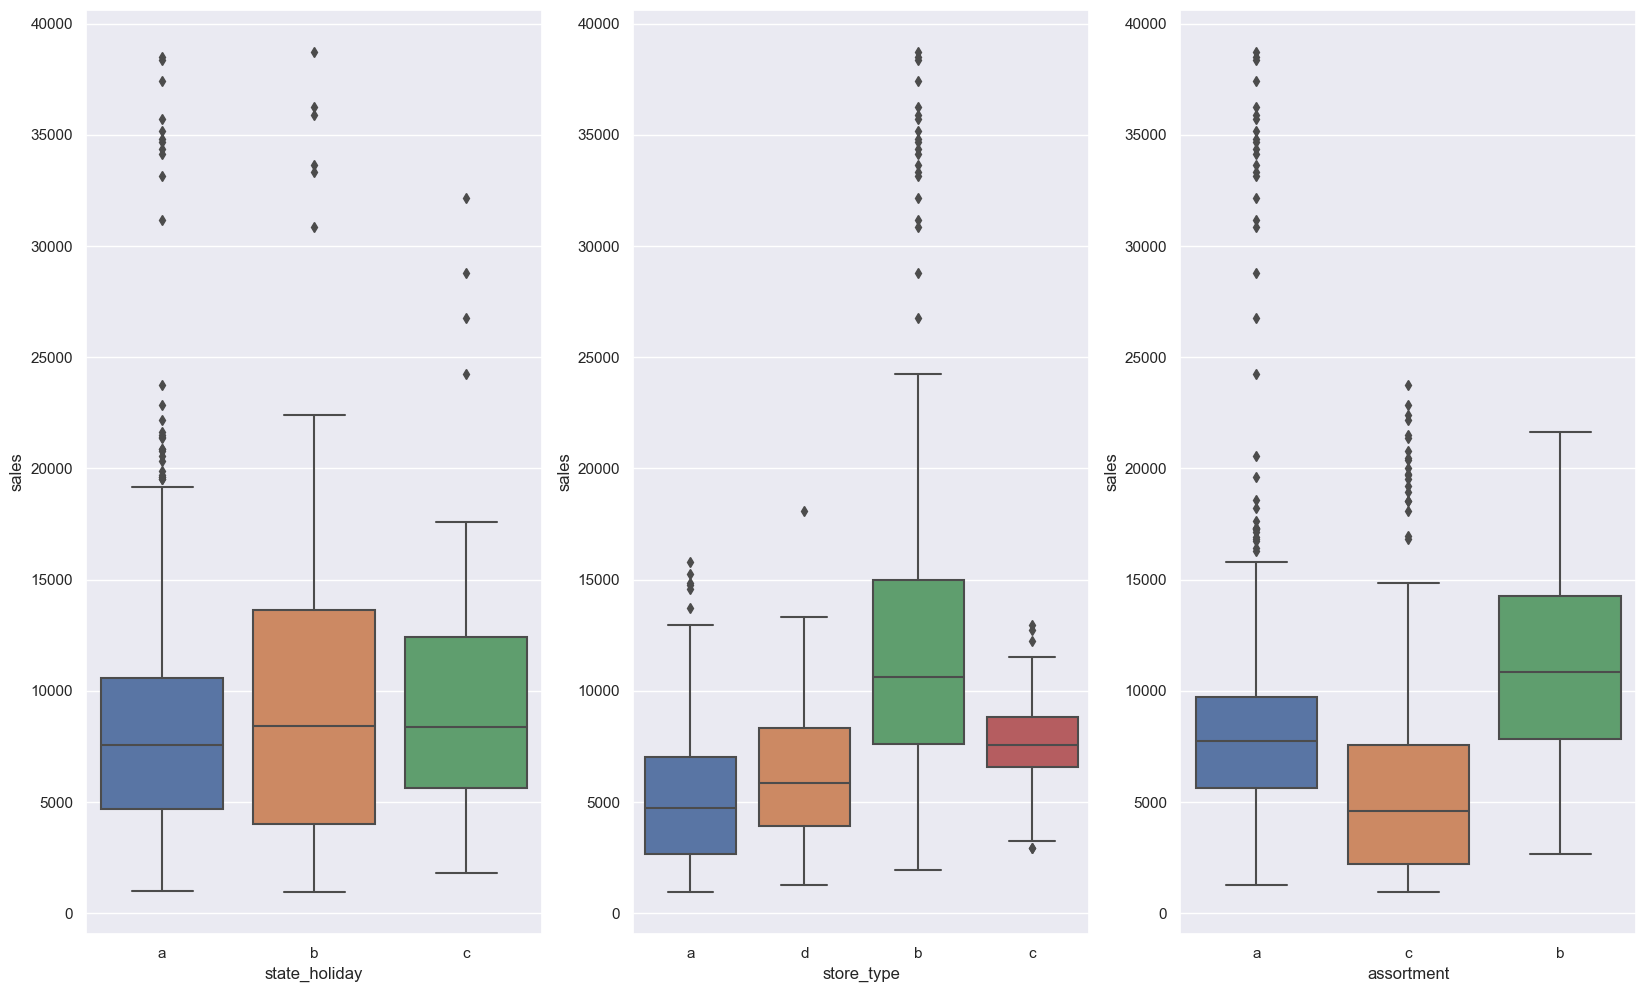

In [16]:
aux1 = df1[ ( df1['state_holiday'] != '0' ) & ( df1['sales'] > 0 ) ]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux1)

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux1)

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux1);

# 2.0. Feature Engineering

In [3]:
# Salvei o df1 como um arquivo csv, para não precisar rodar tudo novamente
df2 = pd.read_csv( 'data/df2.csv', low_memory=False )
df2['date'] = pd.to_datetime( df2['date'] )

## 2.1. Mapa Mental de Hipóteses

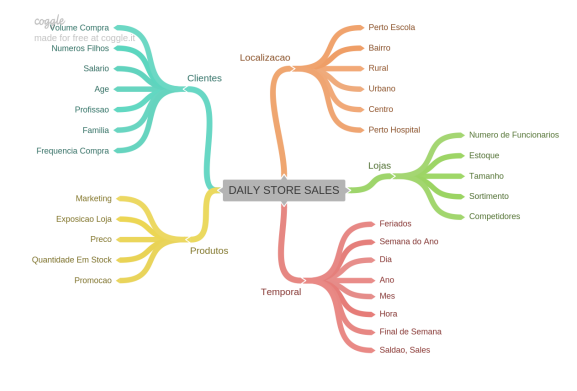

In [4]:
# Mapa Mental de Hipóteses
Image( 'img/image.png' )

## 2.2. Criação de Hipóteses

### 2.2.1 Hipóteses Lojas

**1.** Lojas com maior número de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores a mais tempo deveriam vender mais.

### 2.2.2 Hipóteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas que com maior exposição do produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas ( desconto maiores ) deveriam vender mais.

**5.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções conseccitivas deveriam vender mais.

### 2.2.3 Hipóteses Temporal

**1.** Lojas que abrem no feriado do Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam venderm mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depos do dia 10 de cada mês.

**5.** Lojas deveriam vender menos nos finais de semana.

**6.** Lojas deveriam vender menos nos feriados escolares.

## 2.3. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções conseccitivas deveriam vender mais.

**7.** Lojas que abrem no feriado do Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam venderm mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depos do dia 10 de cada mês.

**11.** Lojas deveriam vender menos nos finais de semana.

**12.** Lojas deveriam vender menos nos feriados escolares.

## 2.4. Feature Engineering

In [5]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(
    lambda x: datetime(year=x['competition_open_since_year'],
                       month=x['competition_open_since_month'],
                       day=1),
    axis=1)

df2['competition_since_month'] = ((df2['date'] - df2['competition_since']) /
                                  30).apply(lambda x: x.days).astype(int)
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(
    str) + '-' + df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(
    lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) /
                          7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(
    lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(
    lambda x: 'public_holiday' if x == 'a' else 'easter_holiday'
    if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

# 3.0. Filtragem de Dados

In [2]:
df3 = pd.read_csv( 'data/df3.csv', low_memory=False )
df3['date'] = pd.to_datetime( df3['date'] )
df3['competition_since'] = pd.to_datetime( df3['competition_since'] )
df3['promo_since'] = pd.to_datetime( df3['promo_since'] )

## 3.1. Filtragem de Linhas

In [3]:
df3 = df3[( df3['open'] != 0 ) & ( df3['sales'] > 0 )]

## 3.2. Seleção de Colunas

In [4]:
cold_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop( cold_drop, axis=1 )

In [5]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_since_month', 'promo_since', 'promo_time_week'],
      dtype='object')

In [6]:
df3.to_csv( 'data/df4.csv', index=False )

# 4.0. Analise Exploratoria de Dados

In [4]:
df4 = pd.read_csv( 'data/df4.csv', low_memory=False )
df4['date'] = pd.to_datetime( df4['date'] )
df4['competition_since'] = pd.to_datetime( df4['competition_since'] )
df4['promo_since'] = pd.to_datetime( df4['promo_since'] )

## 4.1. Analise Univariada

### 4.1.1. Variavel Resposta

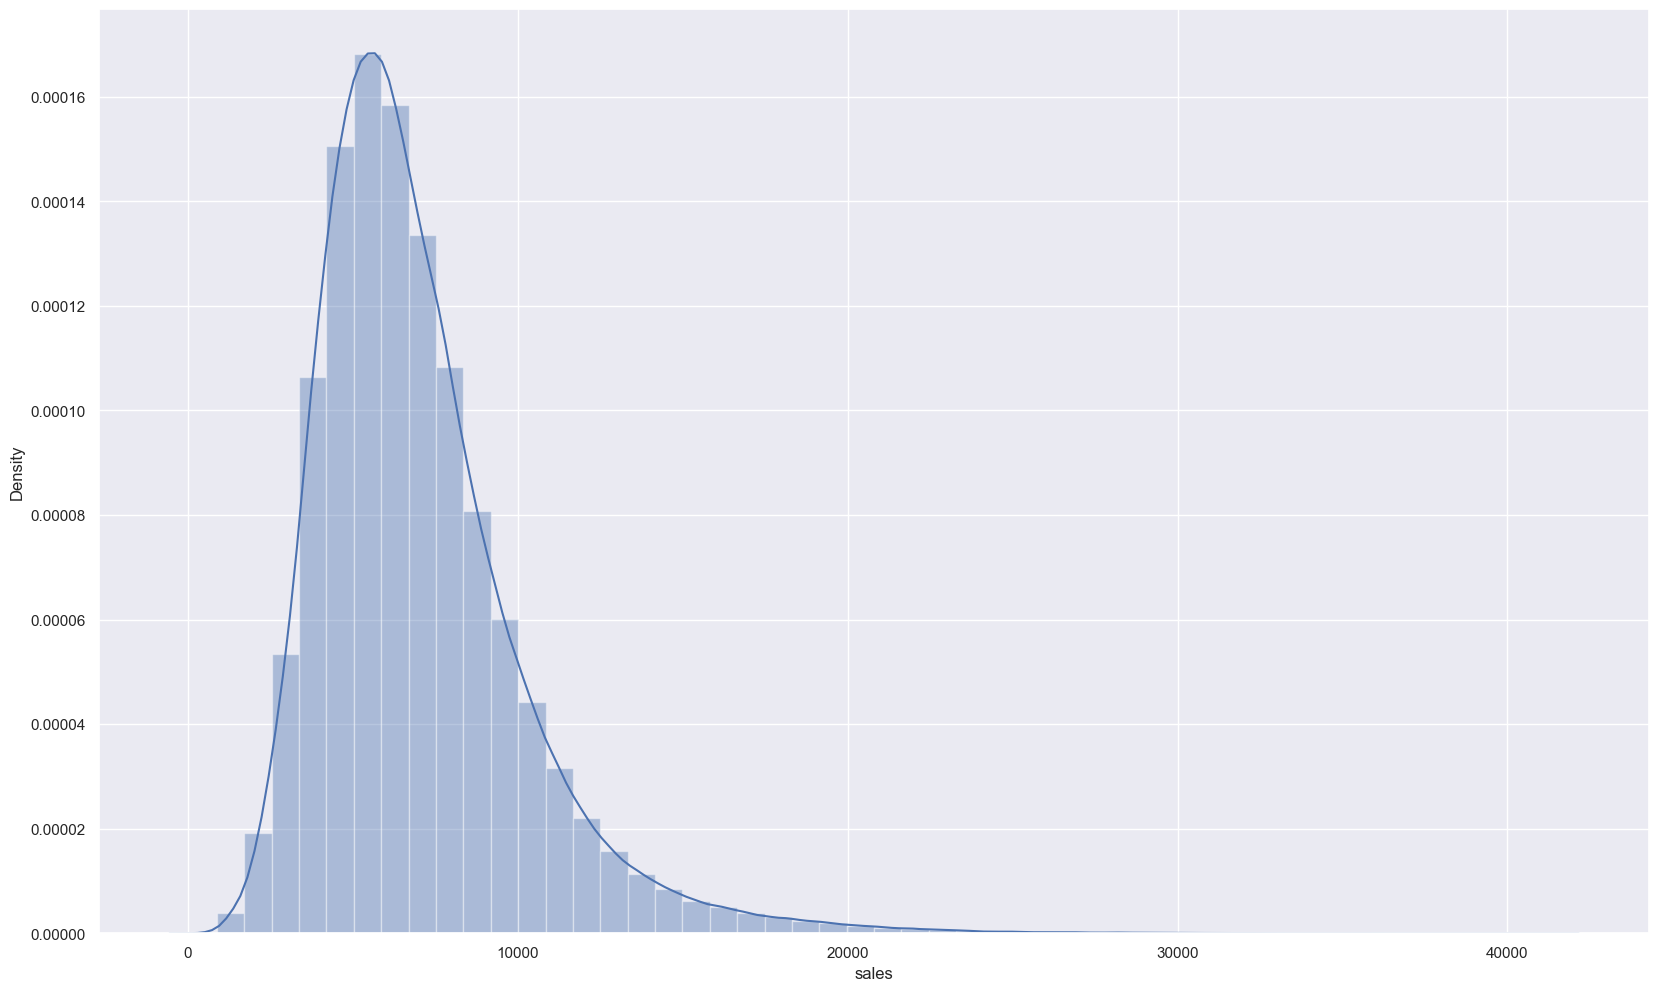

In [5]:
sns.distplot( df4['sales'] ); # kde=False

### 4.1.2. Variavel Numerica

In [6]:
num_attributes = df4.select_dtypes( include=['int64', 'float64'] )

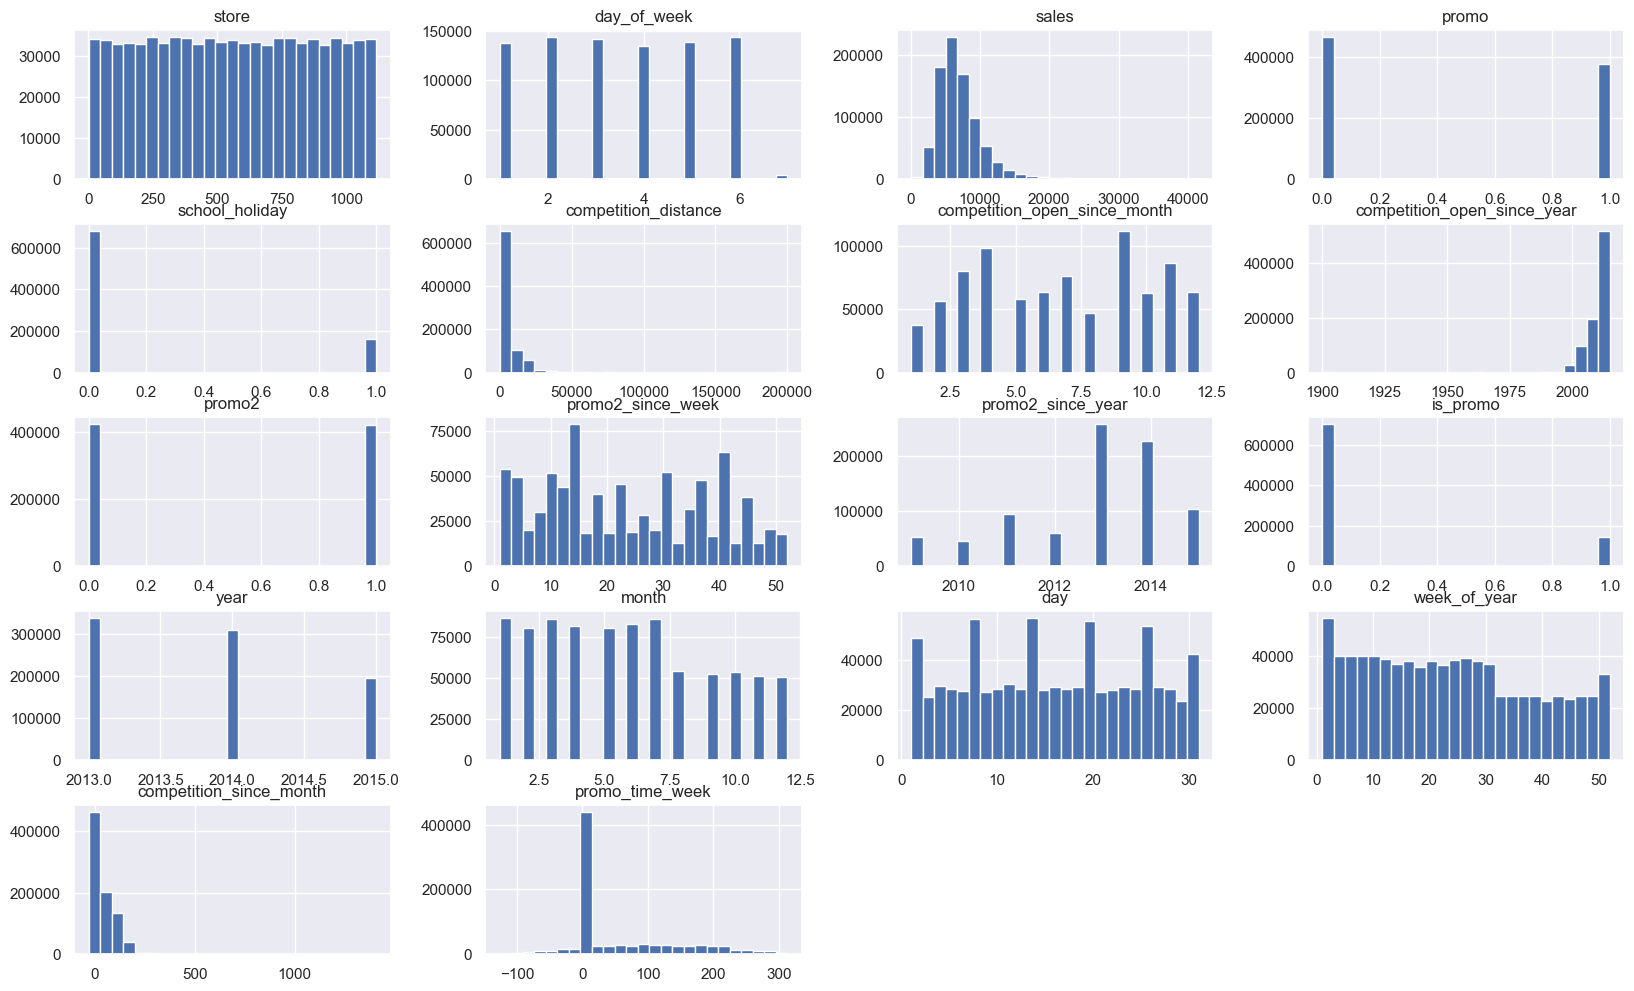

In [7]:
num_attributes.hist( bins=25 );

### 4.1.3. Variavel Categorica

In [8]:
cat_attributes = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

<AxesSubplot:xlabel='sales', ylabel='Density'>

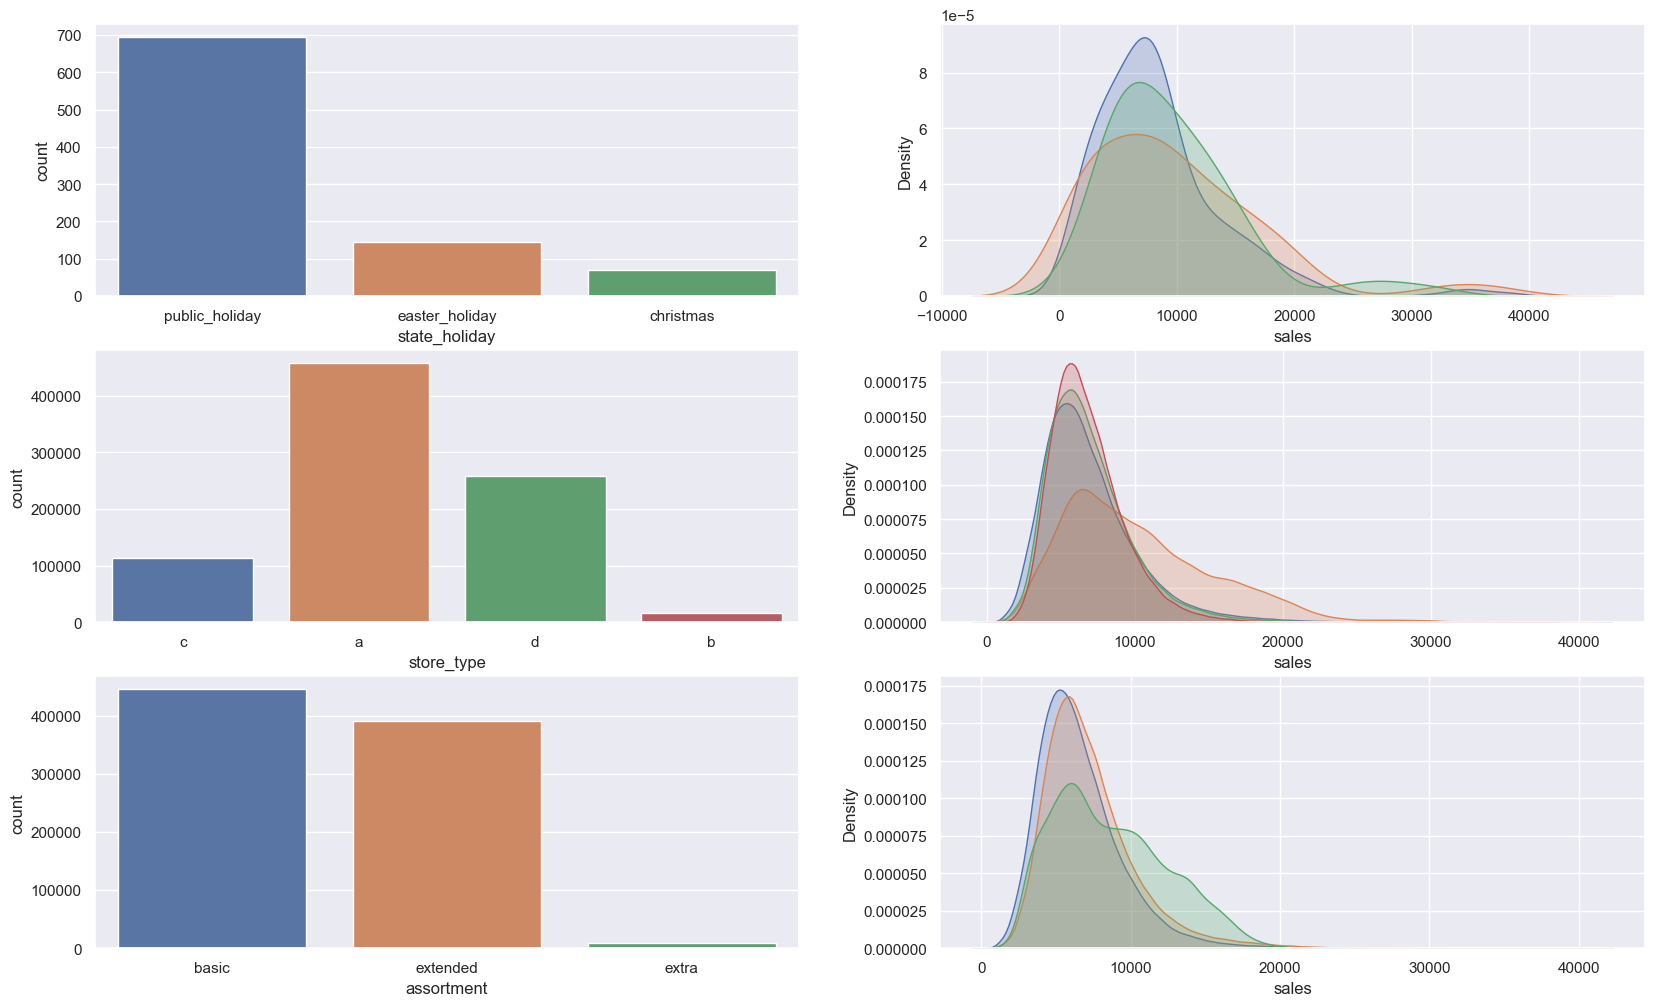

In [9]:
# state holiday
plt.subplot( 3, 2, 1 )

a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot( x=a['state_holiday'] )

plt.subplot( 3, 2, 2 )
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True )
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True )

# store type
plt.subplot( 3, 2, 3 )

sns.countplot( x=df4['store_type'] )

plt.subplot( 3, 2, 4 )
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True )
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True )

# assortment
plt.subplot( 3, 2, 5 )

sns.countplot( x=df4['assortment'] )

plt.subplot( 3, 2, 6 )
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True )
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True )

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimento deveriam vender mais.

**Verdade** Lojas com maior sortimento, na média, vendem mais

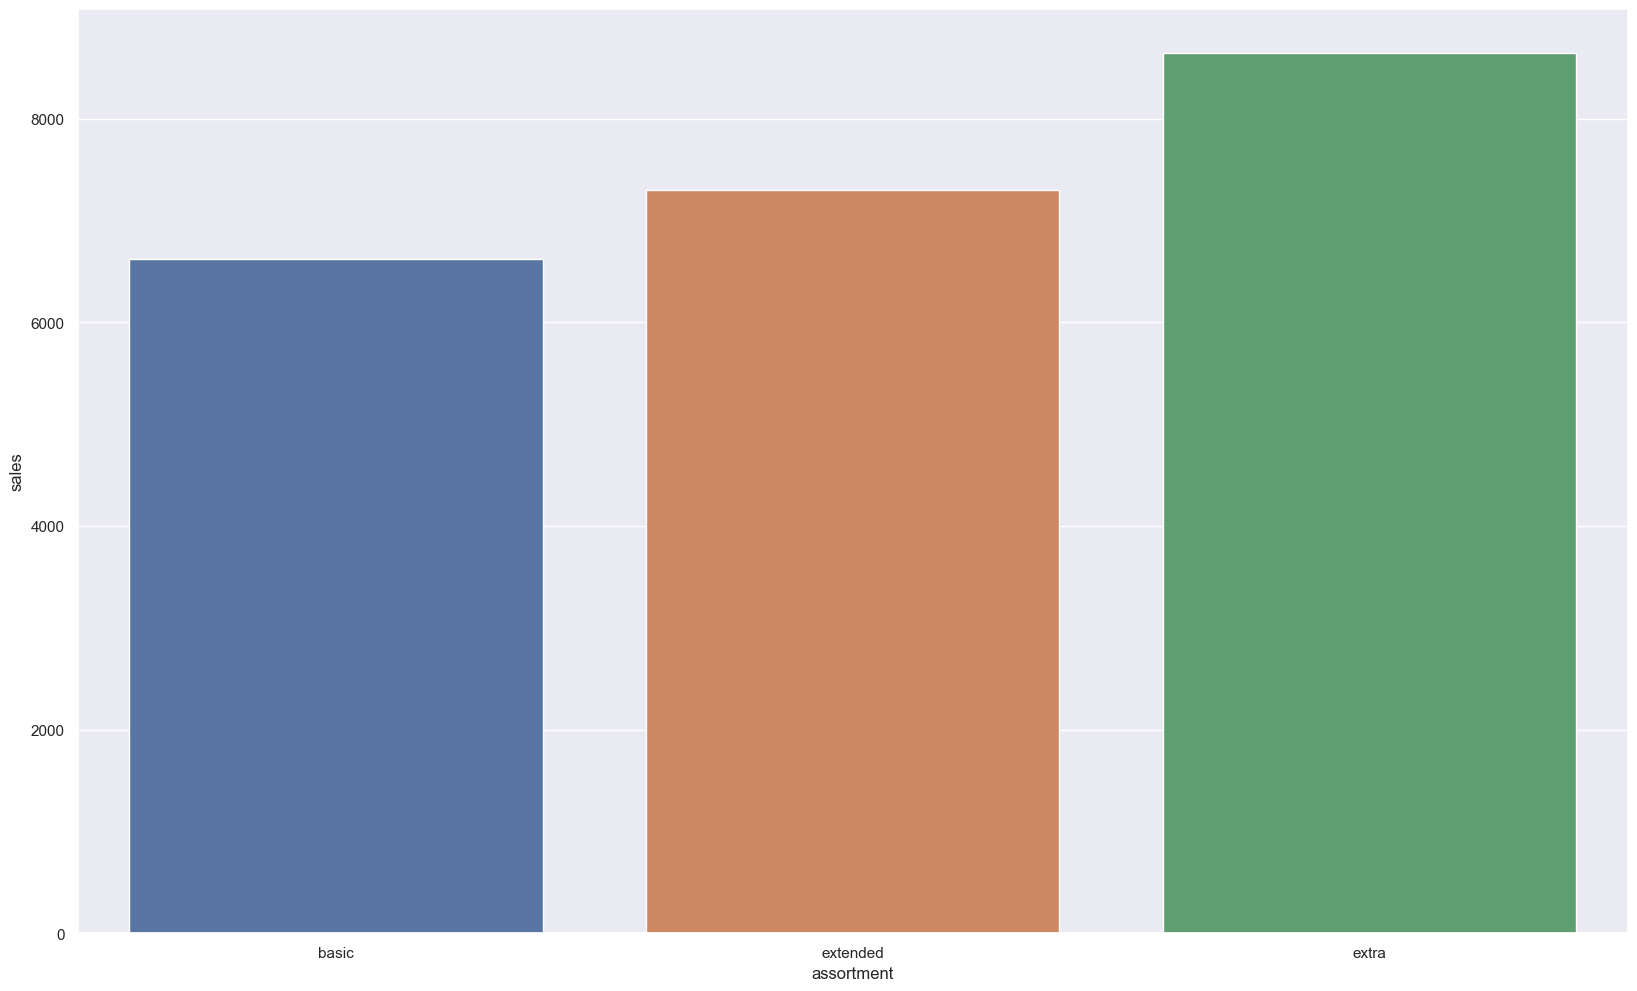

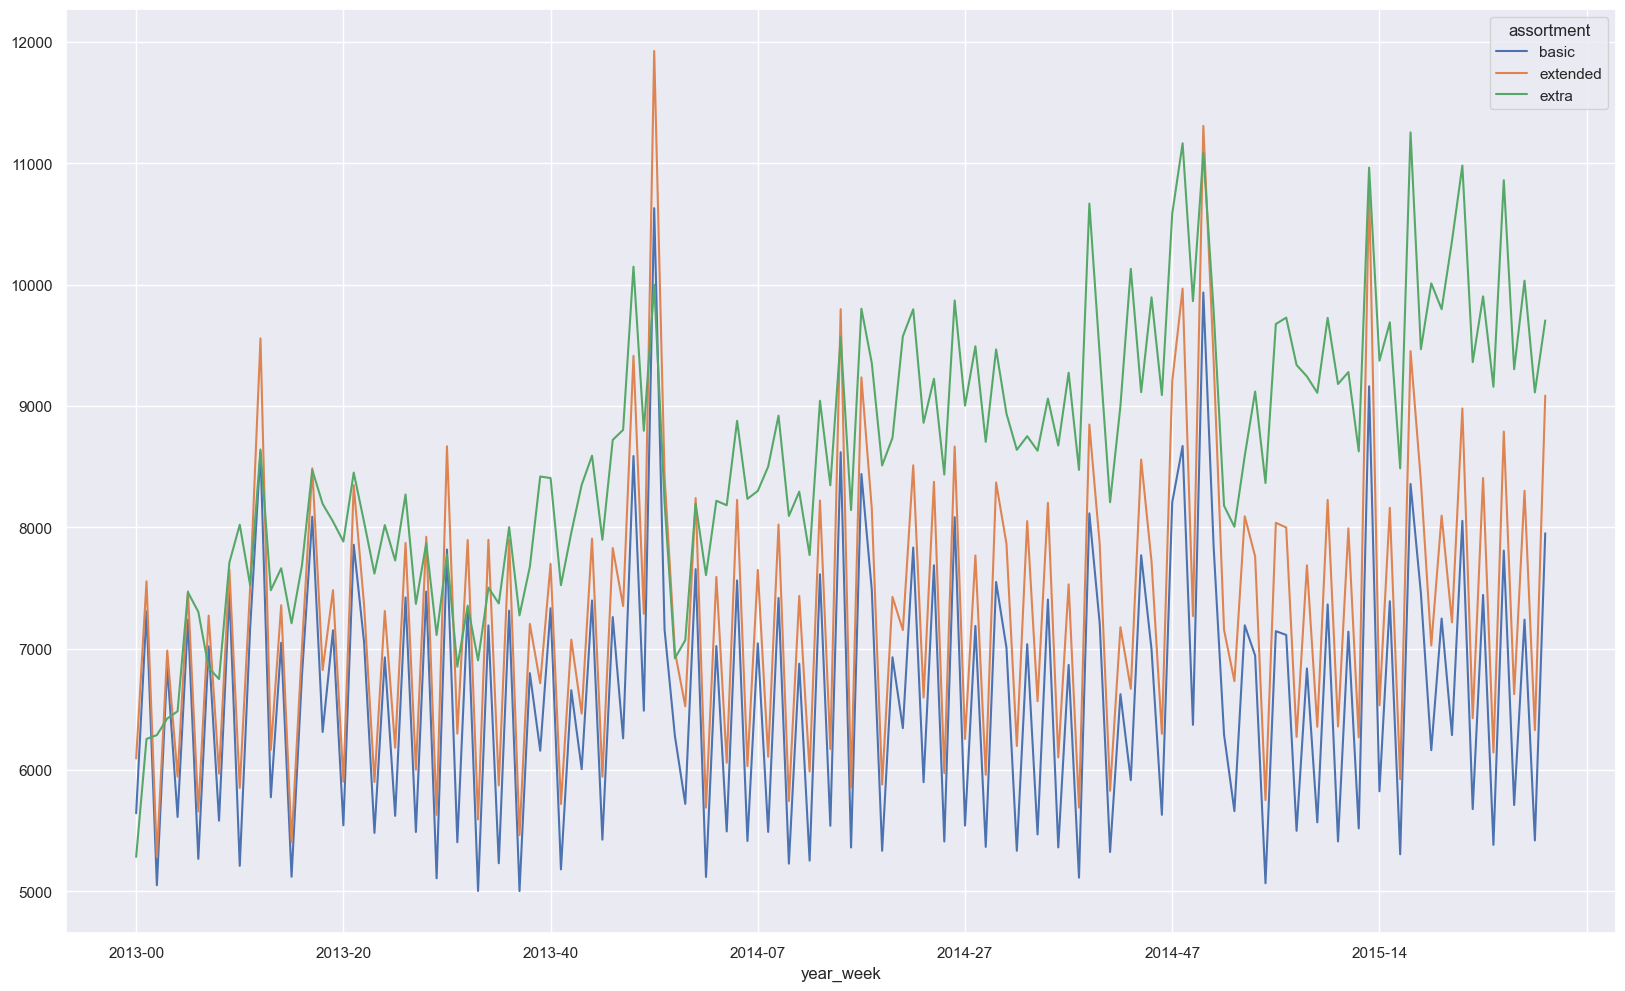

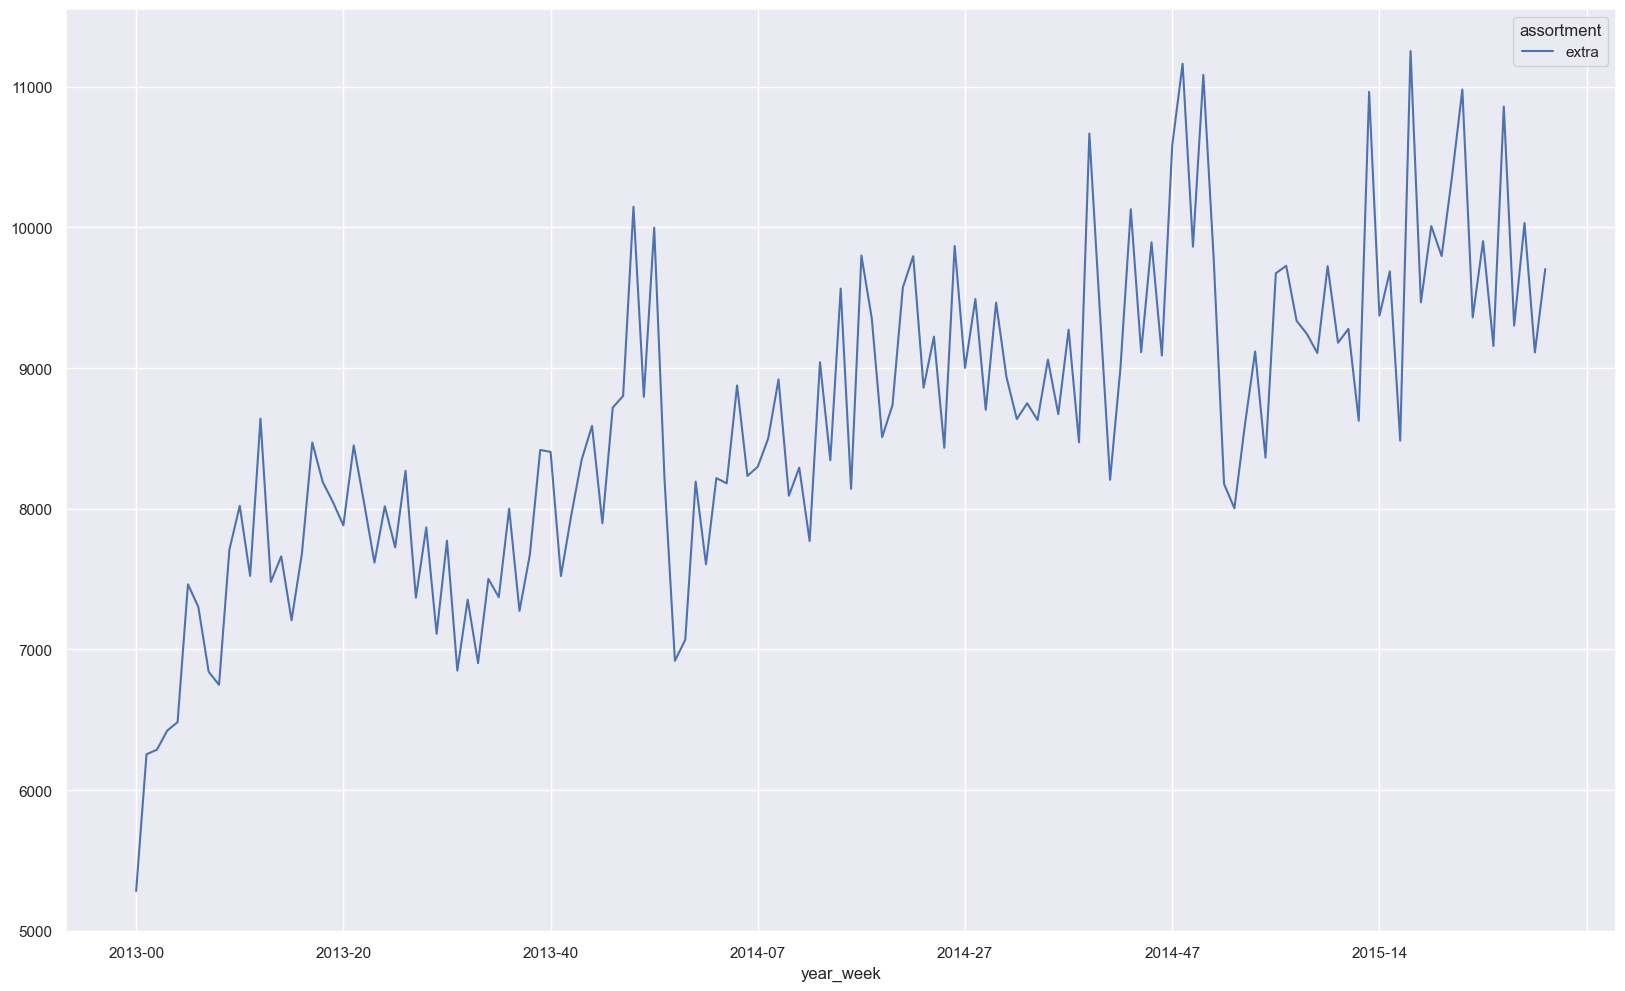

In [10]:
aux1 = df4[['assortment', 'sales']].groupby( 'assortment' ).mean().reset_index()
sns.barplot( x='assortment', y='sales', data=aux1 )

aux2 = df4[['year_week', 'assortment', 'sales']].groupby( ['year_week', 'assortment'] ).mean().reset_index()
aux2.pivot( index='year_week', columns='assortment', values='sales' ).plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot( index='year_week', columns='assortment', values='sales' ).plot();

### **H2.** Lojas com competidores mais próximos deveriam vender menos.

**False** Lojas com competidores mais próximos vendem mais

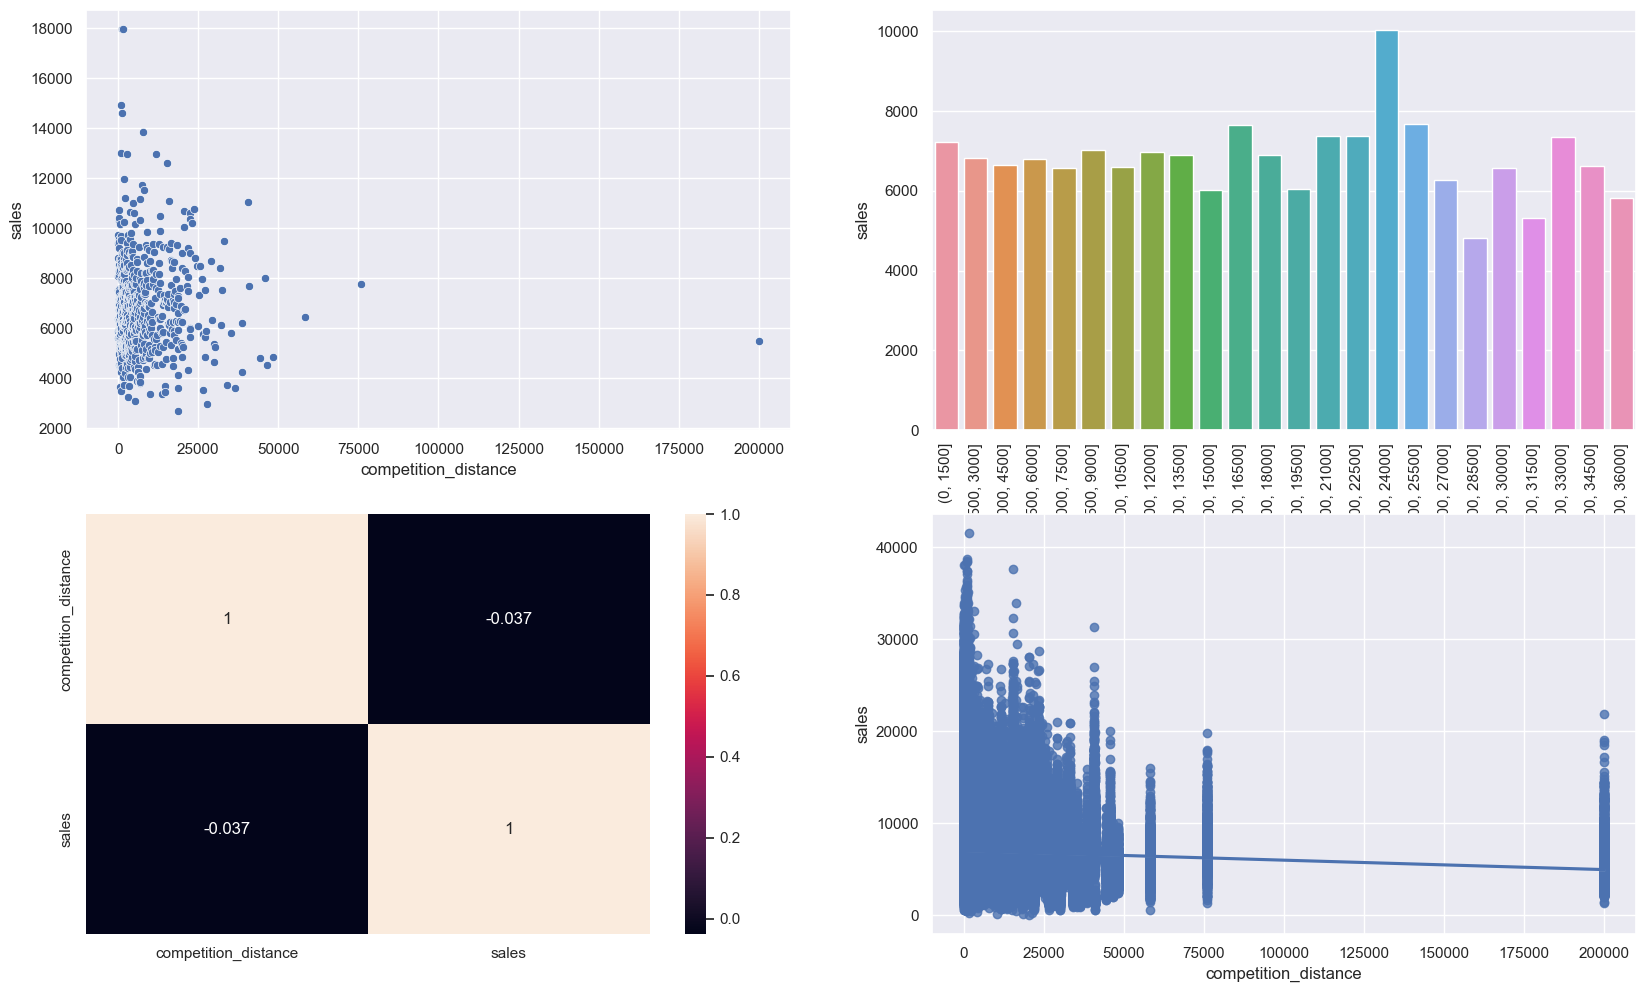

In [11]:
aux1 = df4[['competition_distance', 'sales']].groupby( 'competition_distance' ).mean().reset_index()

plt.subplot( 2, 2, 1 )
sns.scatterplot( x='competition_distance', y='sales', data=aux1 )


plt.subplot( 2, 2, 2 )
bins = list( np.arange( 0, 37000, 1500 ) )
df4['competition_distance_binned'] = pd.cut( df4['competition_distance'], bins=bins )
aux2 = df4[['competition_distance_binned', 'sales']].groupby( 'competition_distance_binned' ).mean().reset_index()
sns.barplot( x='competition_distance_binned', y='sales', data=aux2 )
plt.xticks(rotation=90)


plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )


plt.subplot( 2, 2, 4 )
sns.regplot( x='competition_distance', y='sales', data=df4);

### **H3.** Lojas com competidores a mais tempo deveriam vender mais.

**Verdade** Lojas com competidores por mais tempo vendem mais

In [12]:
df4['competition_year'] = ( ( df4['year'] - df4['competition_open_since_year'] ) )

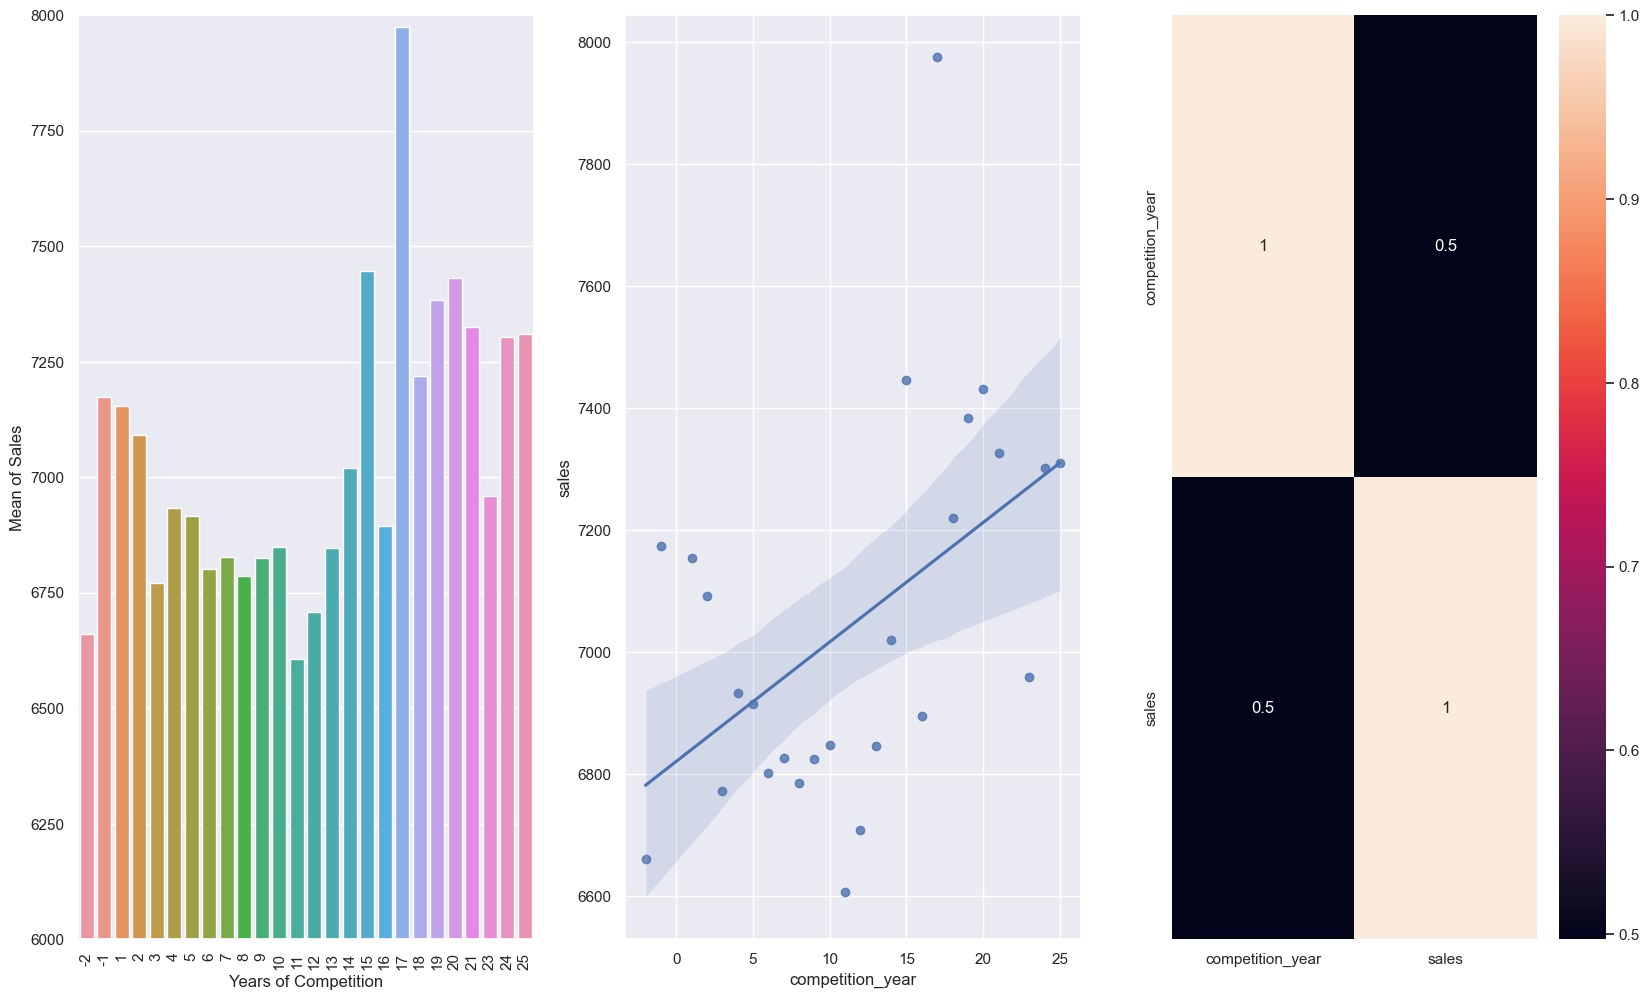

In [13]:
plt.subplot( 1, 3, 1 )
aux1 = df4[['competition_year', 'sales']].groupby( 'competition_year' ).mean().reset_index()
aux2 = aux1[( aux1['competition_year'] <= 26 ) & ( aux1['competition_year'] != 0 )]
ax = sns.barplot( x='competition_year', y='sales', data=aux2 )
ax.set( ylim=( 6000, 8000 ), ylabel='Mean of Sales', xlabel='Years of Competition' )
plt.xticks( rotation=90 )


plt.subplot( 1, 3, 2 )
sns.regplot( x='competition_year', y='sales', data=aux2 )


plt.subplot( 1, 3, 3 )
sns.heatmap( aux2.corr( method='pearson' ), annot=True );

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**Verdade** Com o passar do tempo, promoçoes vendem mais

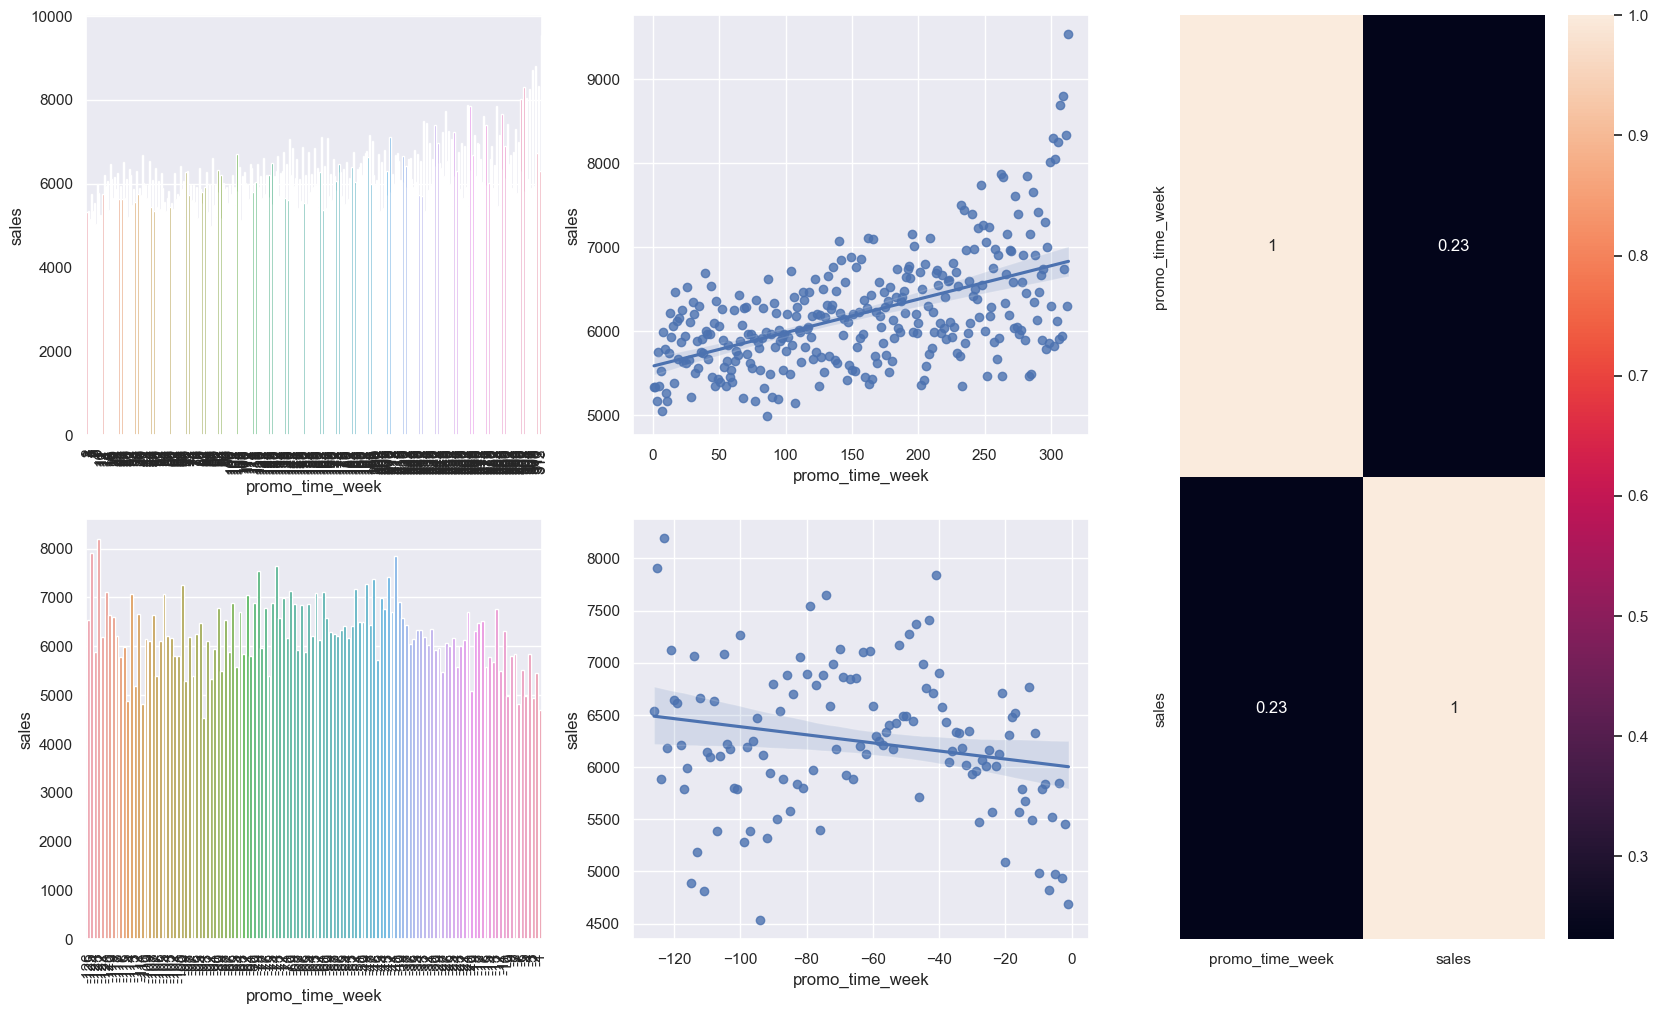

In [14]:
aux3 = df4[['promo_time_week', 'sales']].groupby( 'promo_time_week' ).median().reset_index()

grid = gridspec.GridSpec( 2, 3 )

plt.subplot( grid[0, 0] )
aux1 = aux3[aux3['promo_time_week'] > 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux1 )
plt.xticks( rotation=90 )

plt.subplot( grid[0, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux1 )

plt.subplot( grid[1, 0] )
aux2 = aux3[aux3['promo_time_week'] < 0] # promo extendido
sns.barplot( x='promo_time_week', y='sales', data=aux2 )
plt.xticks( rotation=90 )

plt.subplot( grid[1, 1] )
sns.regplot( x='promo_time_week', y='sales', data=aux2 )

plt.subplot( grid[:, 2] )
sns.heatmap( aux3.corr( method='pearson' ), annot=True );

### <s>**H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

In [15]:
# no feature engenirin fazer quantos dias de promocao tem em cada loja, fazer o groupby, e validar a H

### **H6.** Lojas com mais promoções conseccitivas deveriam vender mais.

**False** Lojas apenas com a promocao tradicional vendem mais

In [16]:
df4[['promo', 'promo2', 'sales']].groupby( ['promo', 'promo2'] ).median().reset_index()

,promo,promo2,sales
0,0,0,5757.0
1,0,1,5181.0
2,1,0,7950.0
3,1,1,7358.0


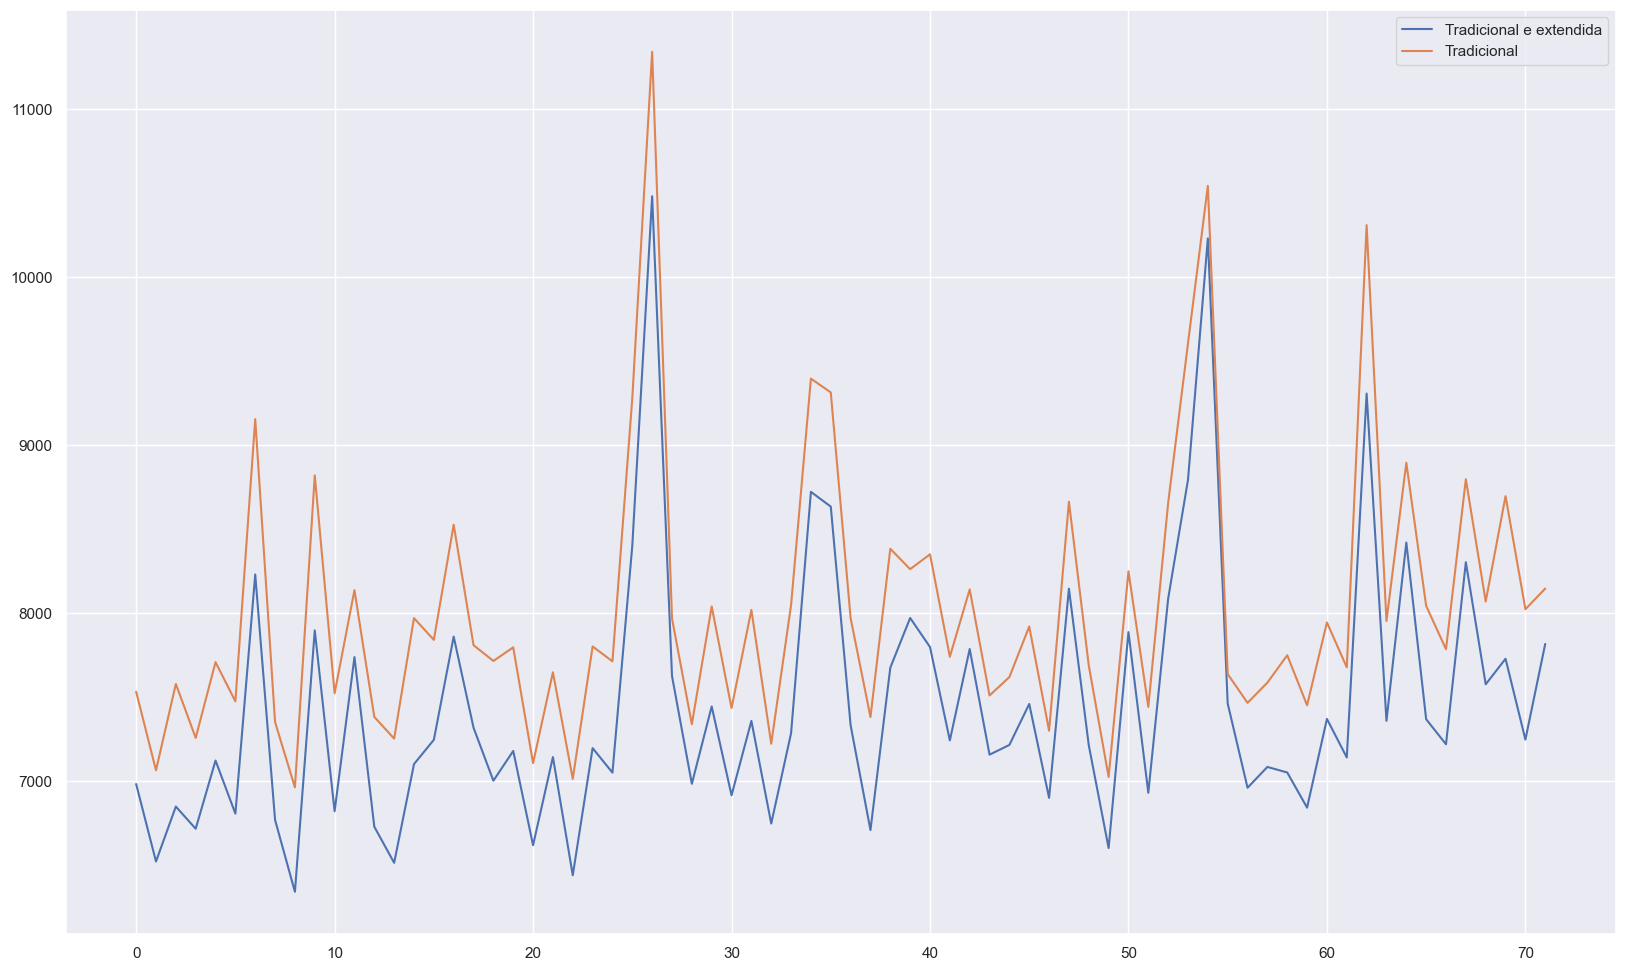

In [17]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week', 'sales']].groupby( 'year_week' ).median().reset_index()
ax = aux1.plot()

aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).median().reset_index()
aux2.plot( ax=ax )

ax.legend( labels=['Tradicional e extendida', 'Tradicional'] )

### **H7** Lojas que abrem no feriado do Natal deveriam vender mais.

**Verdade** O feriado que mais vende é o natal

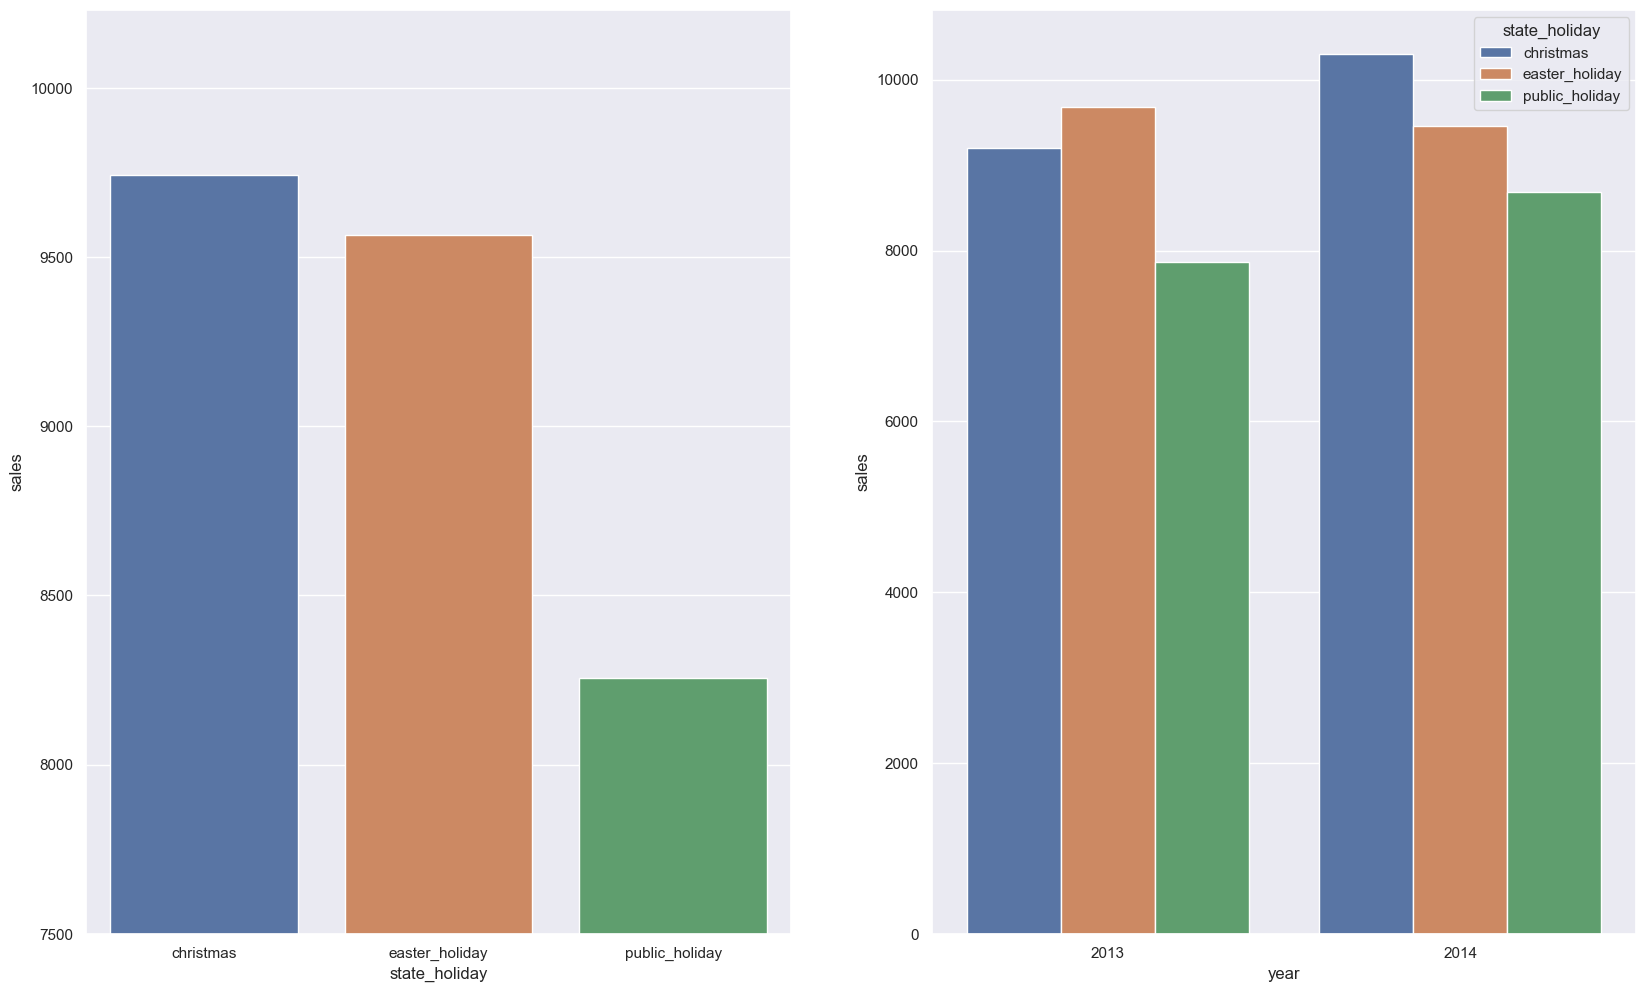

In [18]:
aux = df4[(df4['state_holiday'] != 'regular_day') & (df4['year'] != 2015)]

plt.subplot( 1, 2, 1 )
aux1 = aux[['sales', 'state_holiday']].groupby( 'state_holiday' ).mean().reset_index()
a = sns.barplot( x='state_holiday', y='sales', data=aux1 )
a.set(ylim=(7500, None))

plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year', 'state_holiday'] ).mean().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );

### **H8** Lojas deveriam vender mais ao longo dos anos.

**Verdade** Lojas vendem mais durante os anos

<AxesSubplot:>

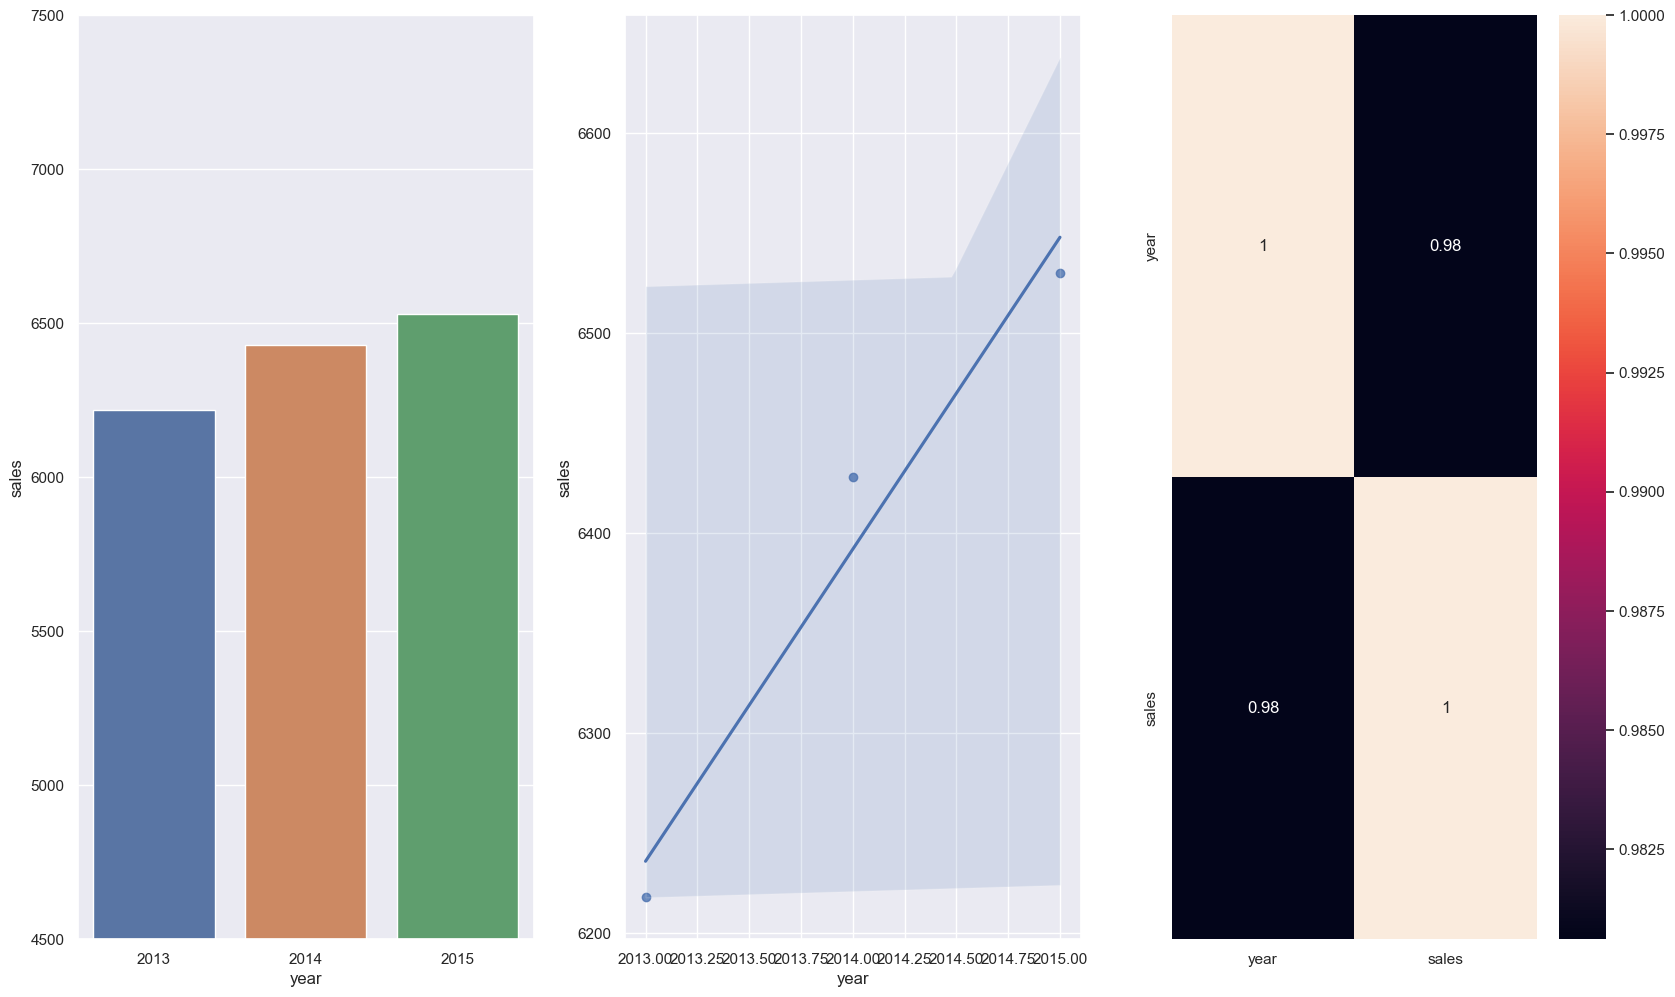

In [19]:
ux = df4[['sales', 'year']].groupby( 'year' ).median().reset_index()

plt.subplot( 1, 3, 1 )
a = sns.barplot( x='year',y='sales', data=ux )
a.set(ylim=(4500, 7500))

plt.subplot( 1, 3, 2 )
sns.regplot( x='year',y='sales', data=ux )

plt.subplot( 1, 3, 3 )
sns.heatmap( ux.corr( method='pearson' ), annot=True )

### **H9** Lojas deveriam venderm mais no segundo semestre do ano.

**Verdade** Lojas vendem mais no segundo semestre do ano, principalmente em dezembro

<AxesSubplot:>

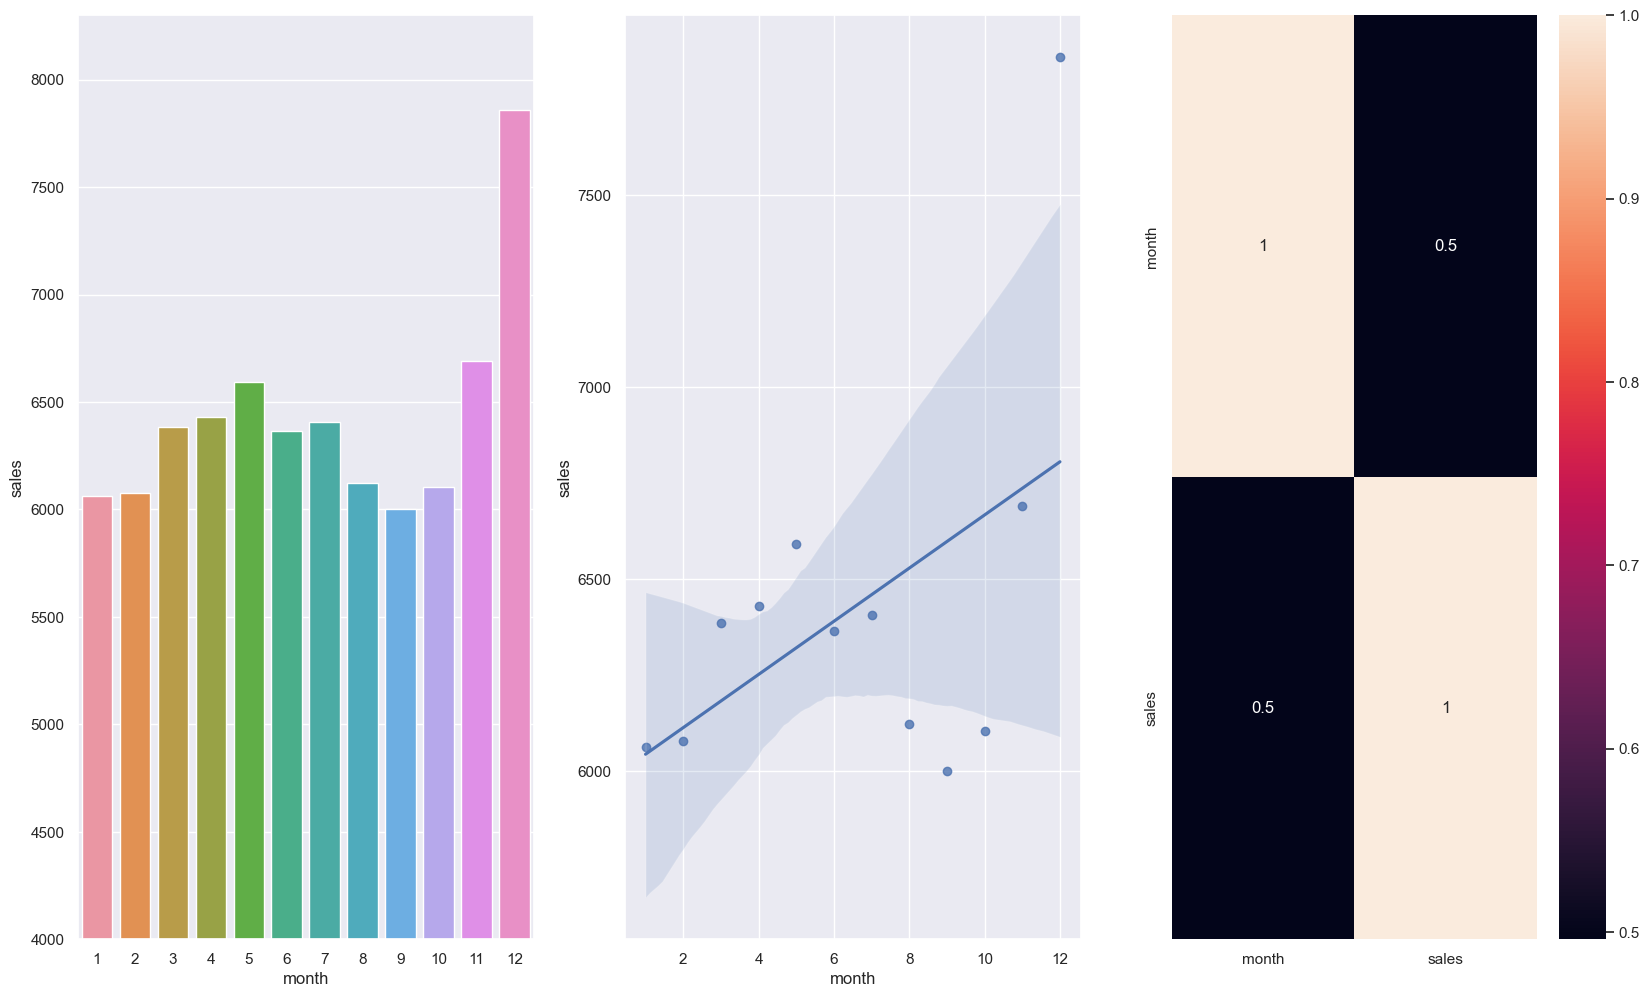

In [20]:
ux = df4[['sales', 'month']].groupby( 'month' ).median().reset_index()

plt.subplot( 1, 3, 1 )
a = sns.barplot( x='month',y='sales', data=ux )
a.set(ylim=(4000, 8300))

plt.subplot( 1, 3, 2 )
sns.regplot( x='month',y='sales', data=ux )

plt.subplot( 1, 3, 3 )
sns.heatmap( ux.corr( method='pearson' ), annot=True )

### **H10** Lojas deveriam vender mais depos do dia 10 de cada mês.

**Falso** Lojas vendem mais até o dia 10 do que depois, na média

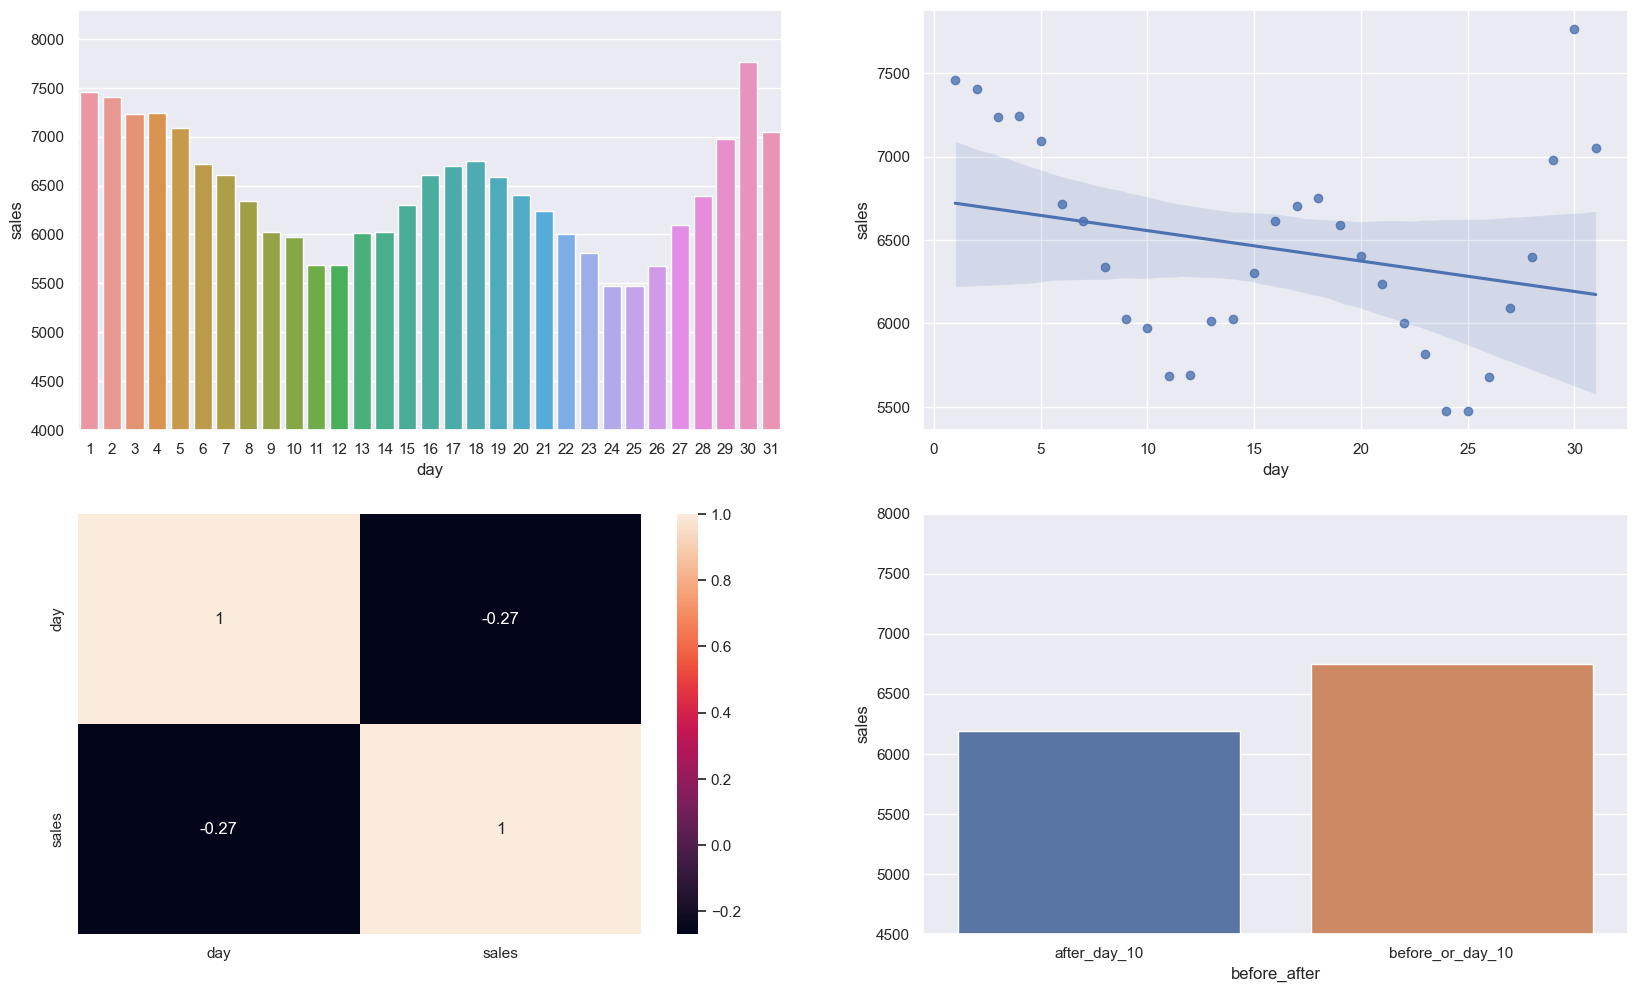

In [21]:
ux = df4[['sales', 'day']].groupby( 'day' ).median().reset_index()

plt.subplot( 2, 2, 1 )
a = sns.barplot( x='day',y='sales', data=ux )
a.set(ylim=(4000, 8300))

plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=ux )

plt.subplot( 2, 2, 3 )
sns.heatmap( ux.corr( method='pearson' ), annot=True )

plt.subplot( 2, 2, 4 )
df4['before_after'] = df4['day'].apply( lambda x: 'before_or_day_10' if x <= 10 else 'after_day_10' )
aux2 = df4[['before_after', 'sales']].groupby( 'before_after' ).median().reset_index()
b = sns.barplot( x='before_after', y='sales', data=aux2 )
b.set(ylim=(4500, 8000));

### **H11** Lojas deveriam vender menos nos finais de semana.
**Verdade** Lojas vendem menos nos finais de semana

<AxesSubplot:xlabel='day_of_week', ylabel='sales'>

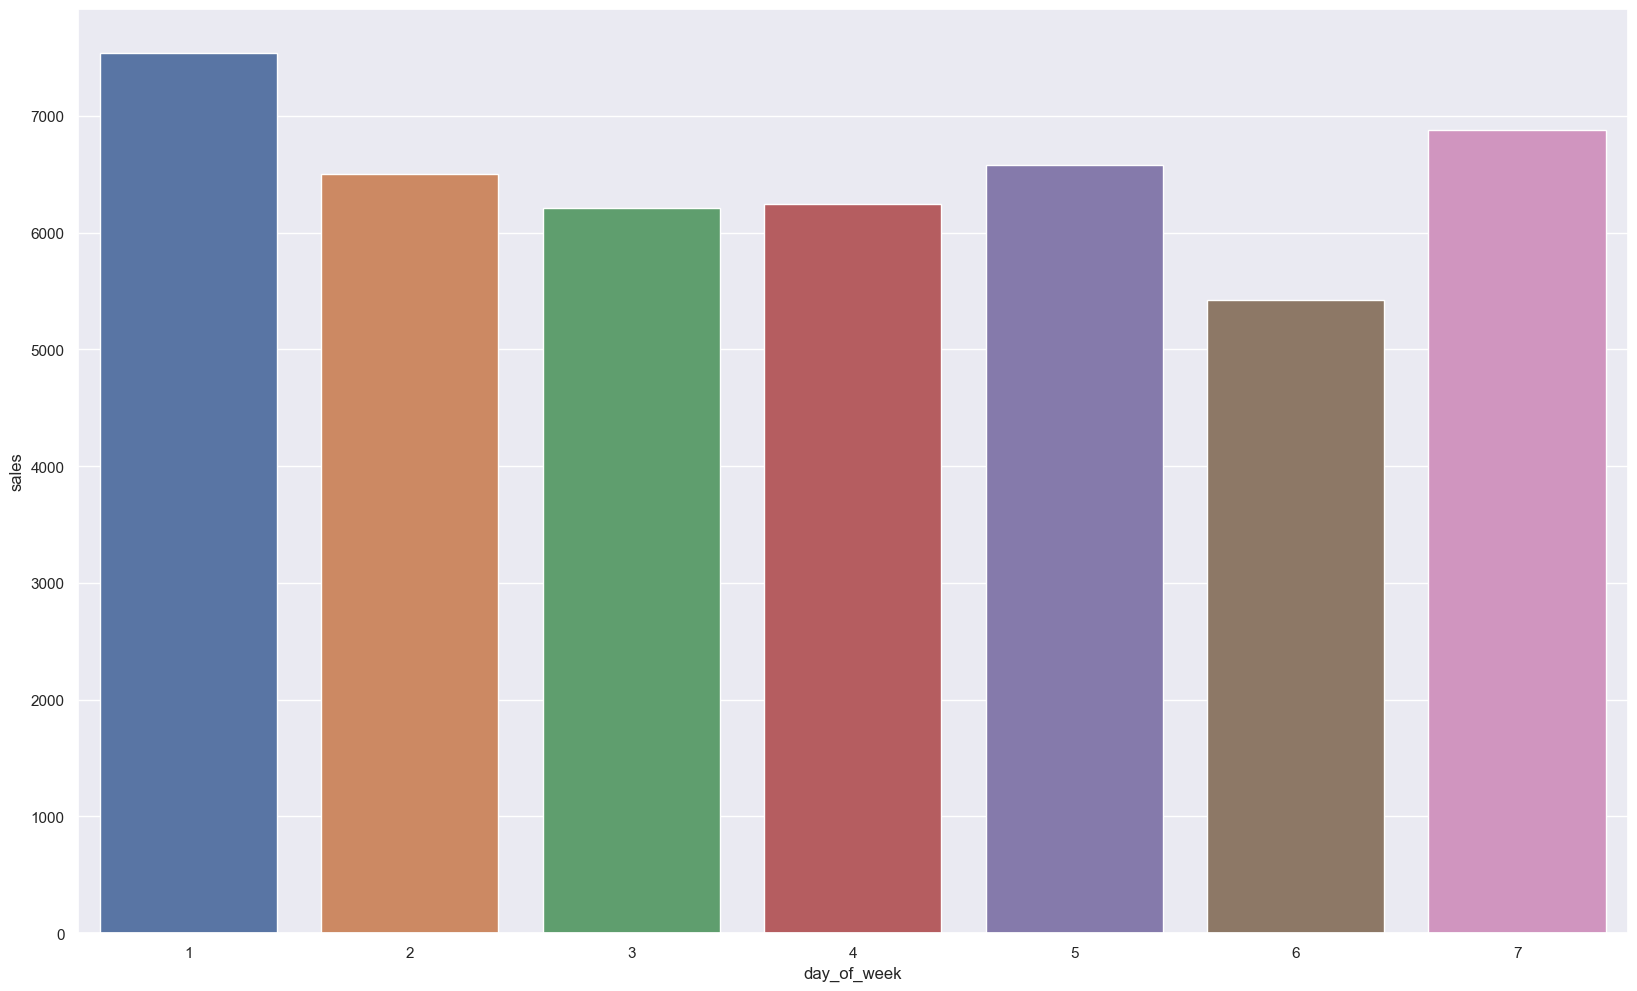

In [22]:
a = df4[['sales', 'day_of_week']].groupby( 'day_of_week' ).median().reset_index()
sns.barplot( x='day_of_week', y='sales', data=a )

<AxesSubplot:>

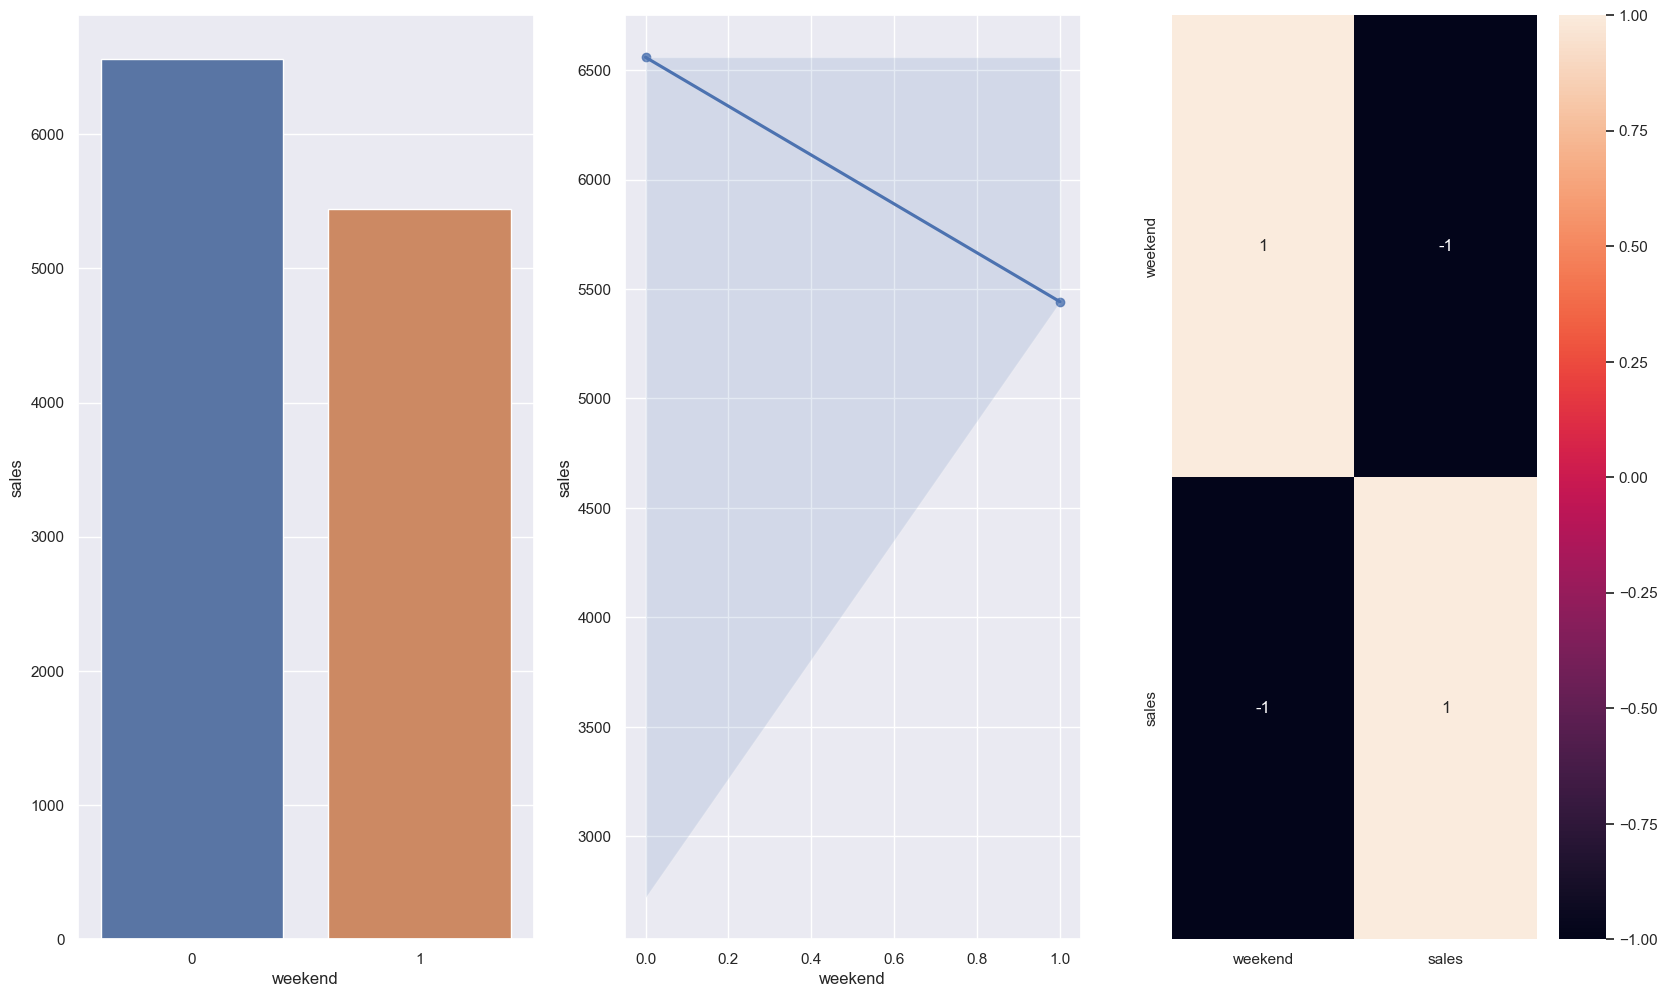

In [23]:
aux1 = df4[['day_of_week', 'sales']]

aux1['weekend'] = aux1['day_of_week'].apply( lambda x: 1 if ((x == 6 ) | (x ==  7)) else 0 )

plt.subplot( 1, 3, 1 )
aux2 = aux1[['weekend', 'sales']].groupby( 'weekend' ).median().reset_index()
sns.barplot( x='weekend', y='sales', data=aux2 )

plt.subplot( 1, 3, 2 )
sns.regplot( x='weekend', y='sales', data=aux2 )

plt.subplot( 1, 3, 3 )
sns.heatmap( aux2.corr( method='pearson' ), annot=True )

### **H12** Lojas deveriam vender menos nos feriados escolares.
**False** Lojas vendem mais nos feriados escolares, exeto dezembro

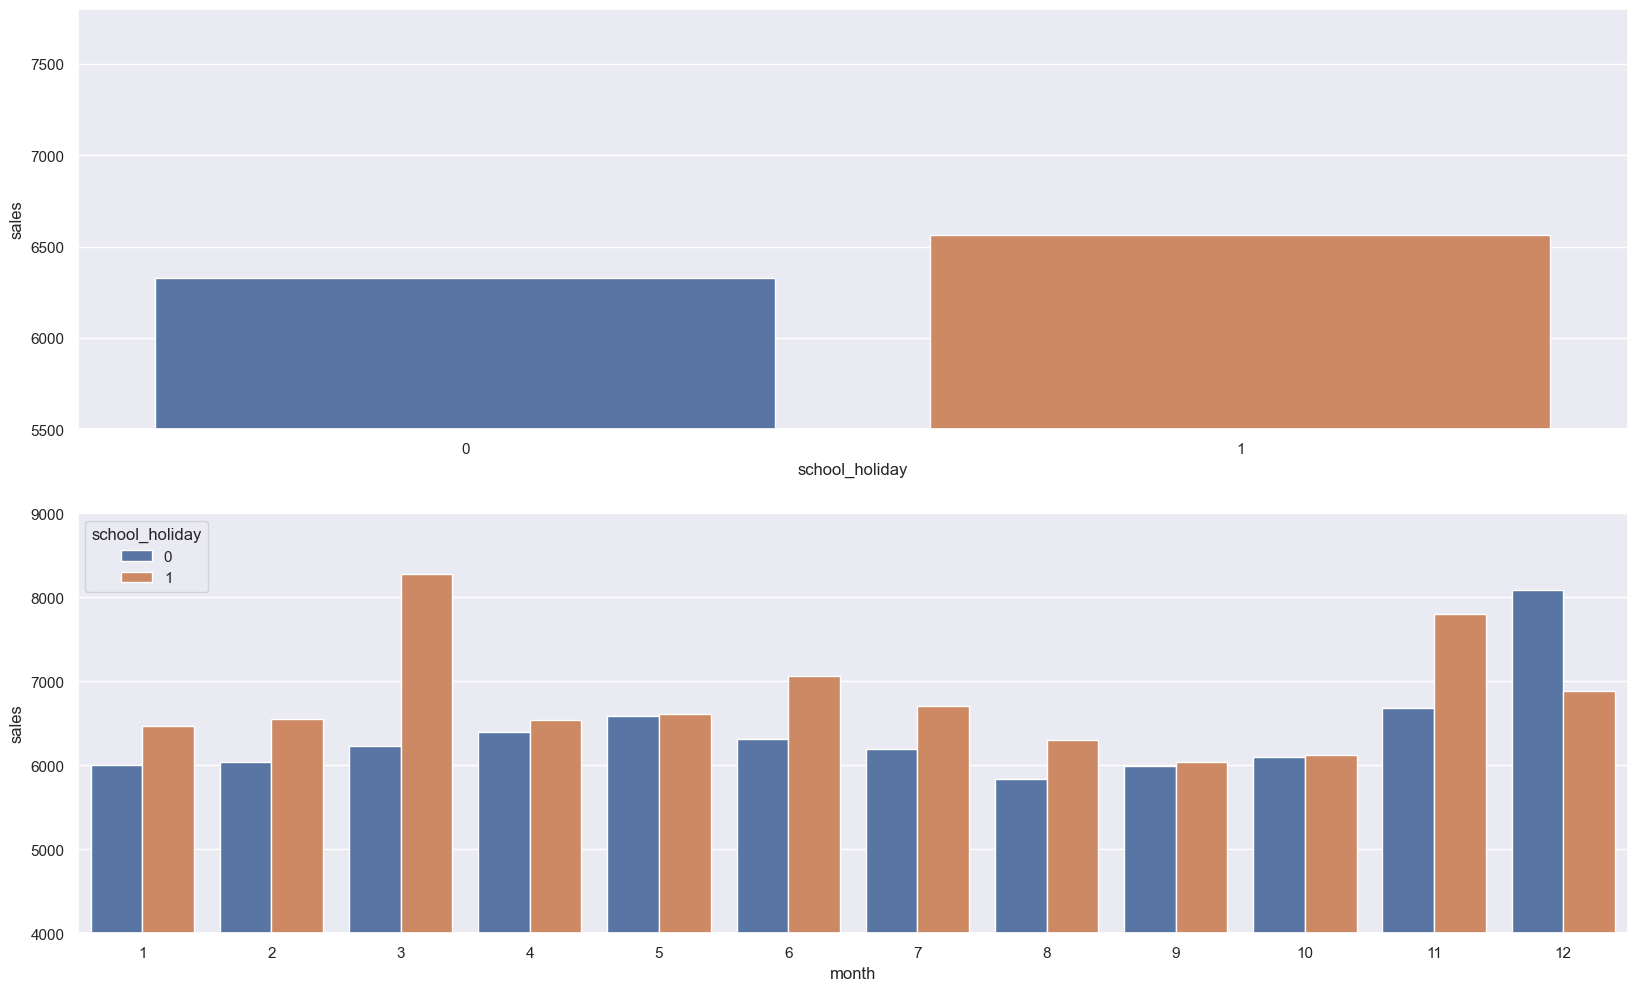

In [24]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).median().reset_index()

plt.subplot( 2, 1, 1 )
a = sns.barplot( x='school_holiday', y='sales', data=aux1 )
a.set(ylim=(5500, 7800))

plt.subplot( 2, 1, 2 )
aux2 = df4[['school_holiday', 'sales', 'month']].groupby( ['month', 'school_holiday'] ).median().reset_index()
b = sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 )
b.set(ylim=(4000, 9000));

## 4.2.1 Resumo de Hipoteses

In [25]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
      ['H1', 'Verdadeira', 'Alta'],  
      ['H2', 'Falsa', 'Baixa'],  
      ['H3', 'Verdadeira', 'Media'],
      ['H4', 'Verddadeira', 'Baixa'],
      ['H5', '-', '-'],
      ['H6', 'Falsa', 'Media'],
      ['H7', 'Verdade', 'Baixa'],
      ['H8', 'Verdade', 'Alta'],
      ['H9', 'Verdade', 'Alta'],
      ['H10', 'Falso', 'Media'],
      ['H11', 'Verdadeira', 'Media'],
      ['H12', 'Falso', 'Media'],
     ]  
print( tabulate( tab, headers='firstrow' ) )

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Verdadeira   Alta
H2           Falsa        Baixa
H3           Verdadeira   Media
H4           Verddadeira  Baixa
H5           -            -
H6           Falsa        Media
H7           Verdade      Baixa
H8           Verdade      Alta
H9           Verdade      Alta
H10          Falso        Media
H11          Verdadeira   Media
H12          Falso        Media


## 4.3. Analise Multivariada

### Atributos Numericos

<AxesSubplot:>

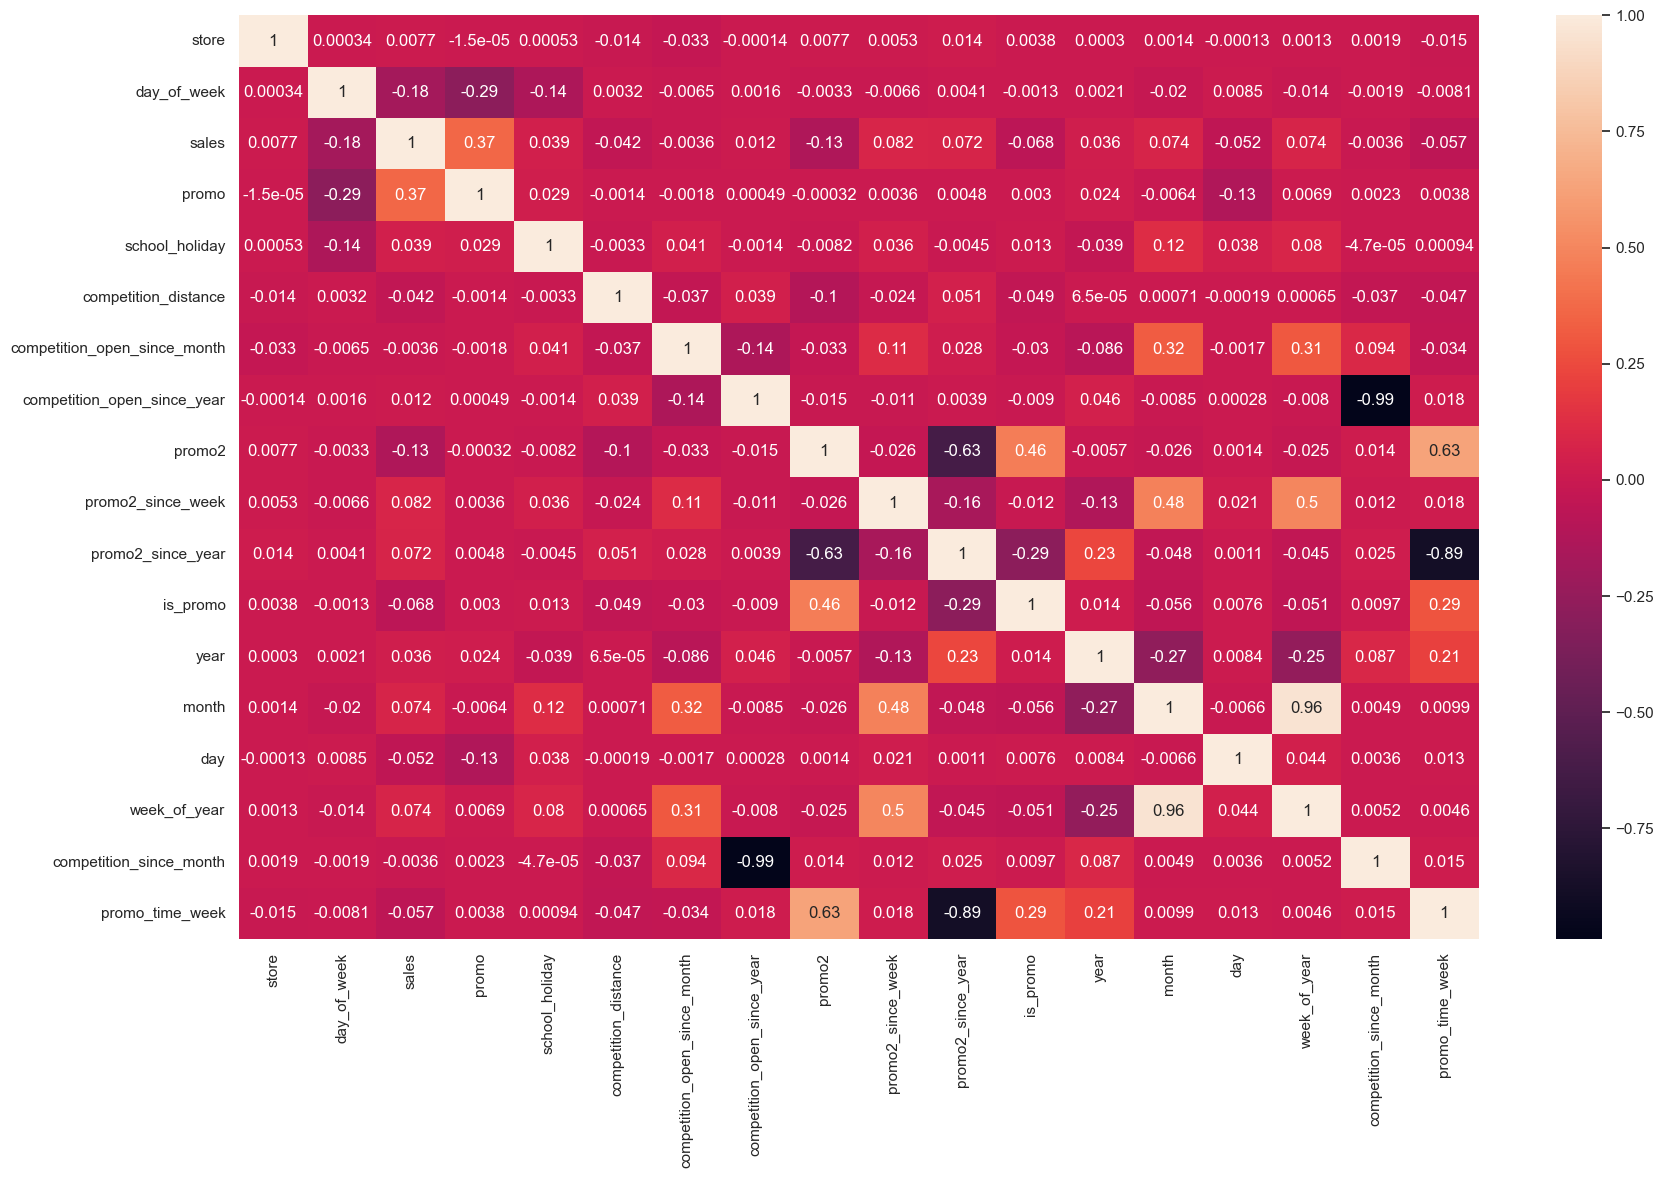

In [26]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True )

### Atributos Categoricos

In [27]:
cat_attributes = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
cat_attributes = cat_attributes.drop(['year_week', 'competition_distance_binned'], axis=1)

<AxesSubplot:>

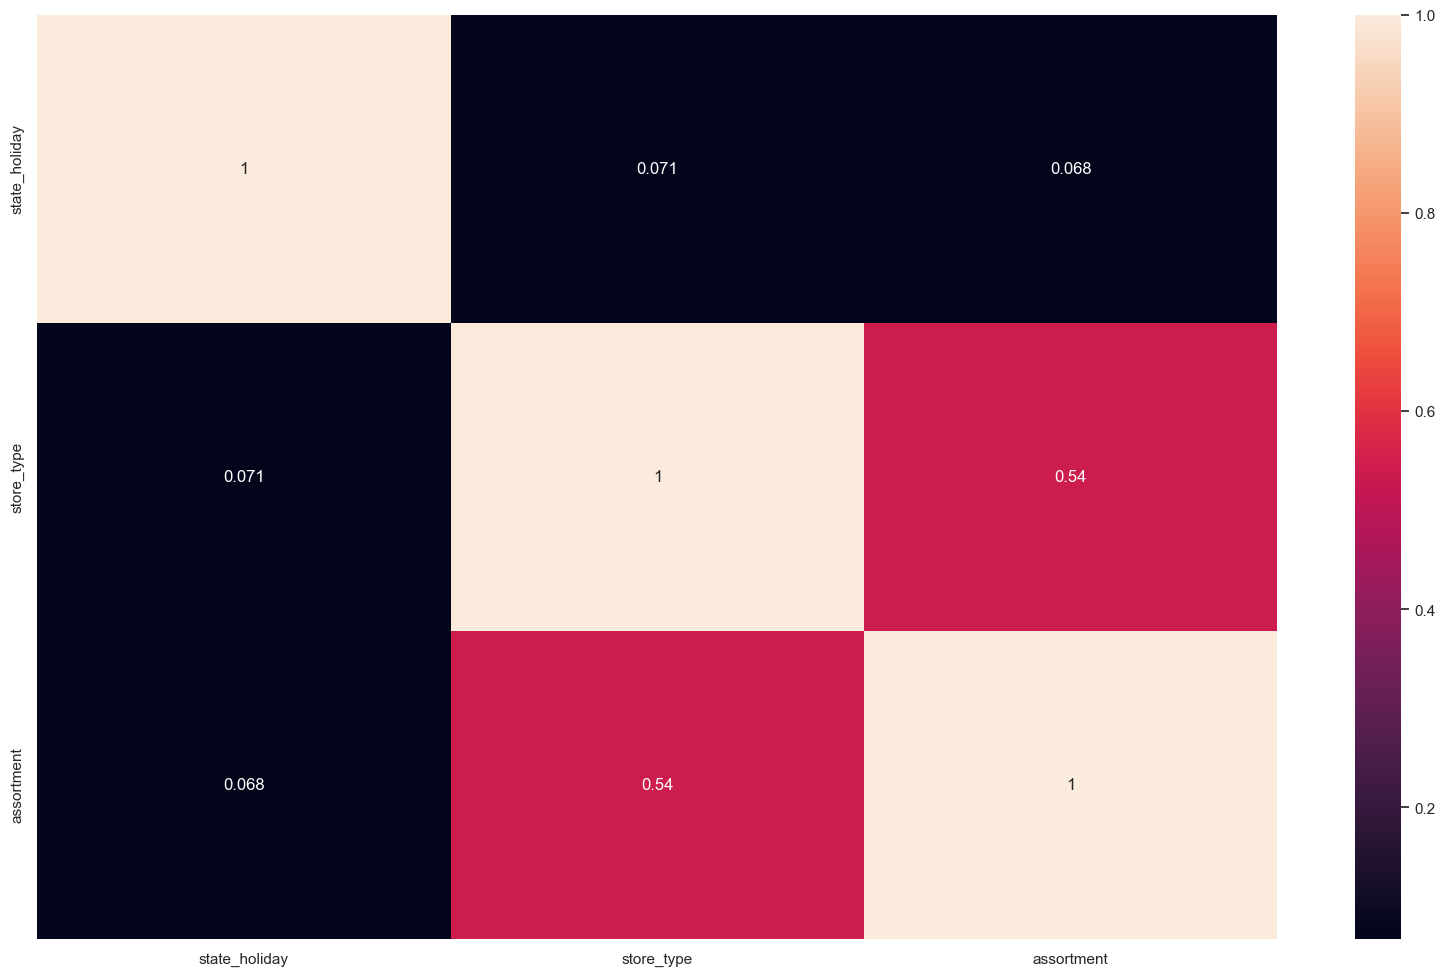

In [28]:
a1 = cramer_v( cat_attributes['state_holiday'], cat_attributes['state_holiday'] )
a2 = cramer_v( cat_attributes['state_holiday'], cat_attributes['store_type'] )
a3 = cramer_v( cat_attributes['state_holiday'], cat_attributes['assortment'] )

a4 = cramer_v( cat_attributes['store_type'], cat_attributes['state_holiday'] )
a5 = cramer_v( cat_attributes['store_type'], cat_attributes['store_type'] )
a6 = cramer_v( cat_attributes['store_type'], cat_attributes['assortment'] )

a7 = cramer_v( cat_attributes['assortment'], cat_attributes['state_holiday'] )
a8 = cramer_v( cat_attributes['assortment'], cat_attributes['store_type'] )
a9 = cramer_v( cat_attributes['assortment'], cat_attributes['assortment'] )

d = pd.DataFrame( { 'state_holiday': [a1, a2, a3],
                'store_type': [a4, a5, a6],
                'assortment': [a7, a8, a9]
              } )

d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

# 5.0. Preparacao dos Dados

In [2]:
df5 = pd.read_csv( 'data/df5.csv', low_memory=False )
df5['date'] = pd.to_datetime( df5['date'] )
df5['competition_since'] = pd.to_datetime( df5['competition_since'] )
df5['promo_since'] = pd.to_datetime( df5['promo_since'] )

## 5.1. Normalizacao

Nao tem variaveis normais, entao a normalizacao nao se aplica em nehum caso

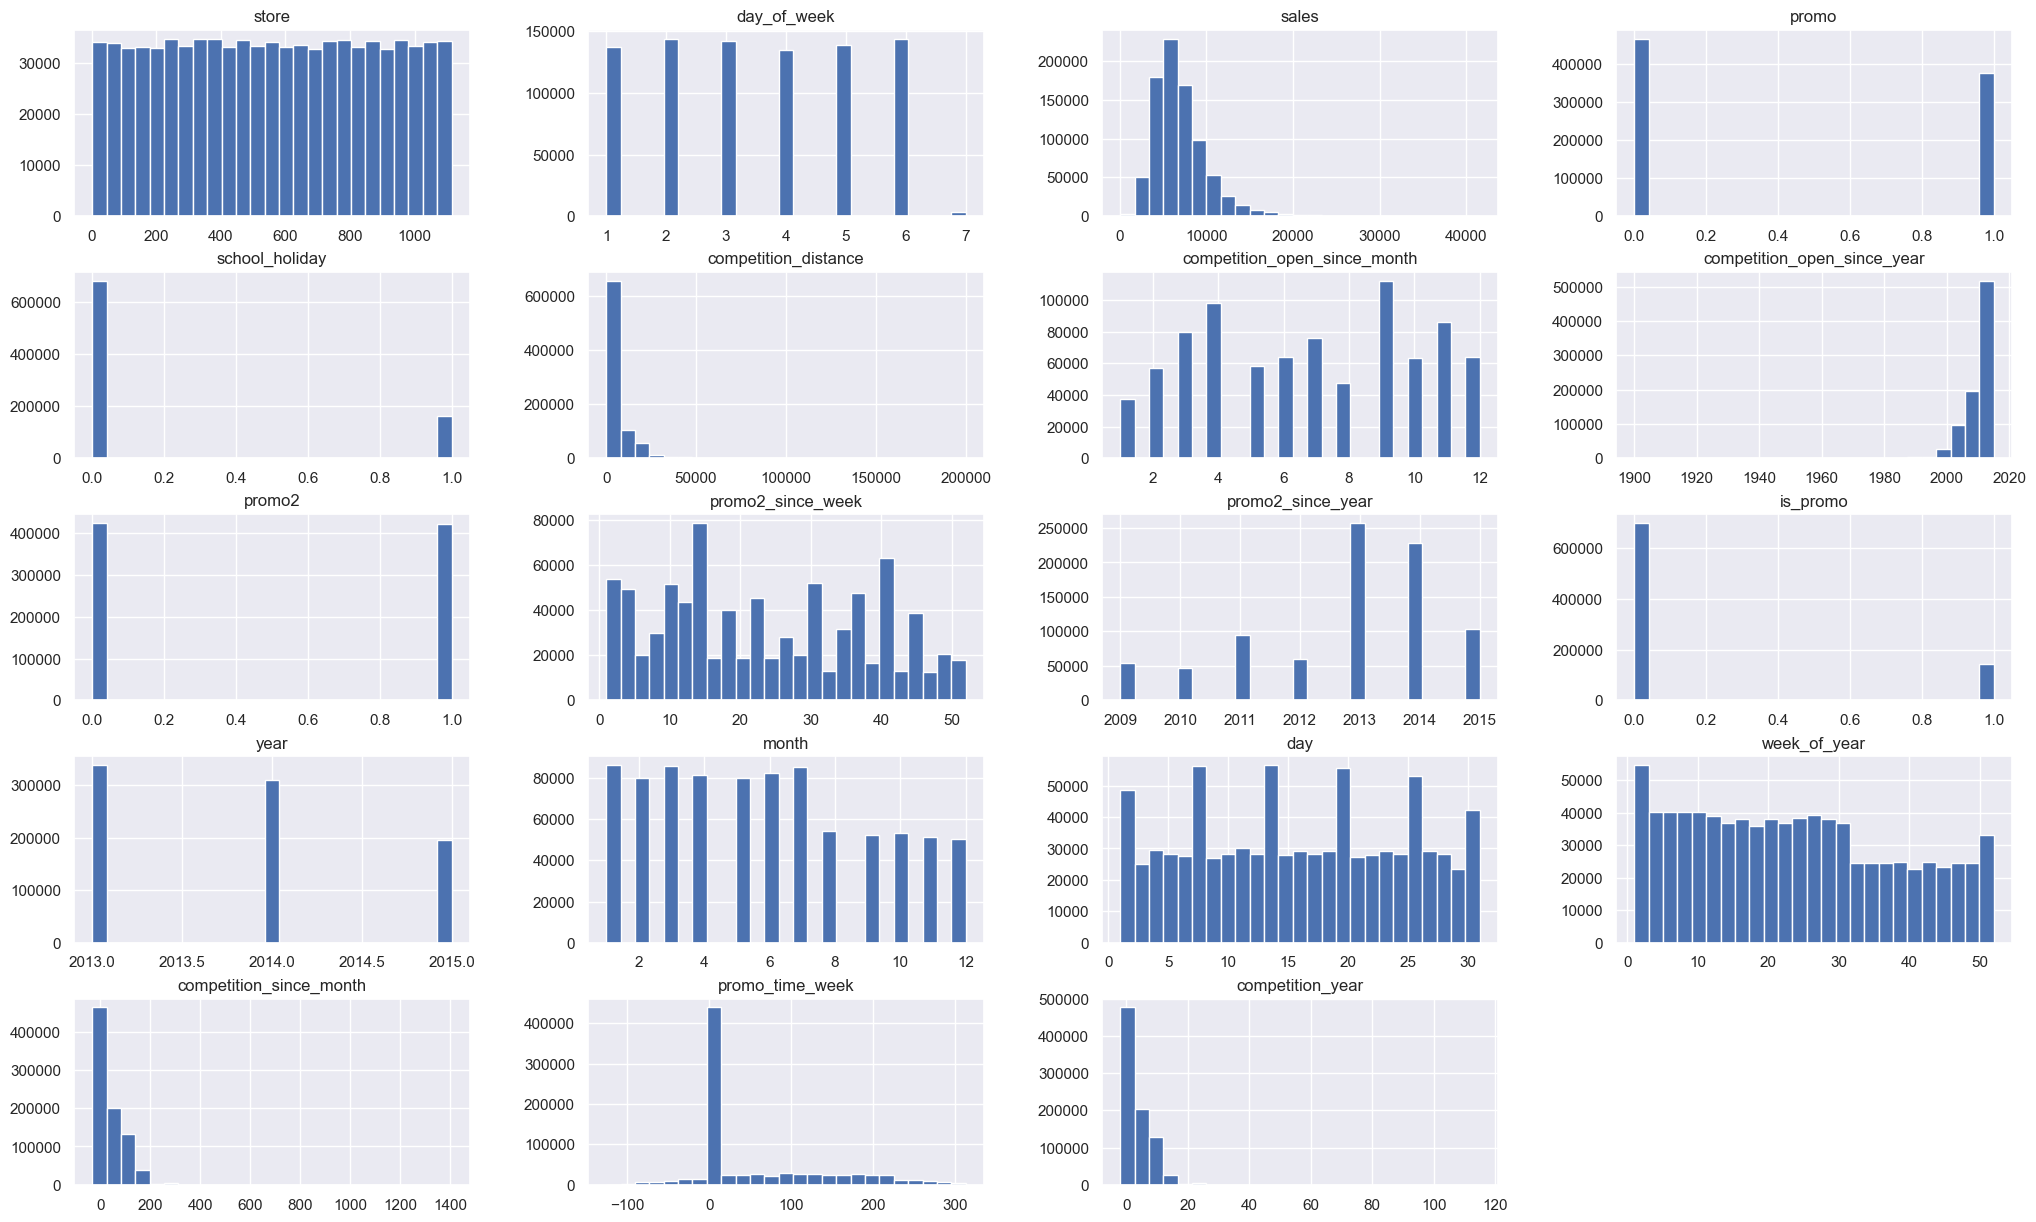

In [3]:
num_attributes = df5.select_dtypes( include=['int64', 'float64'] )

num_attributes.hist( bins=25 );

## 5.2. Redimensionando

<AxesSubplot:>

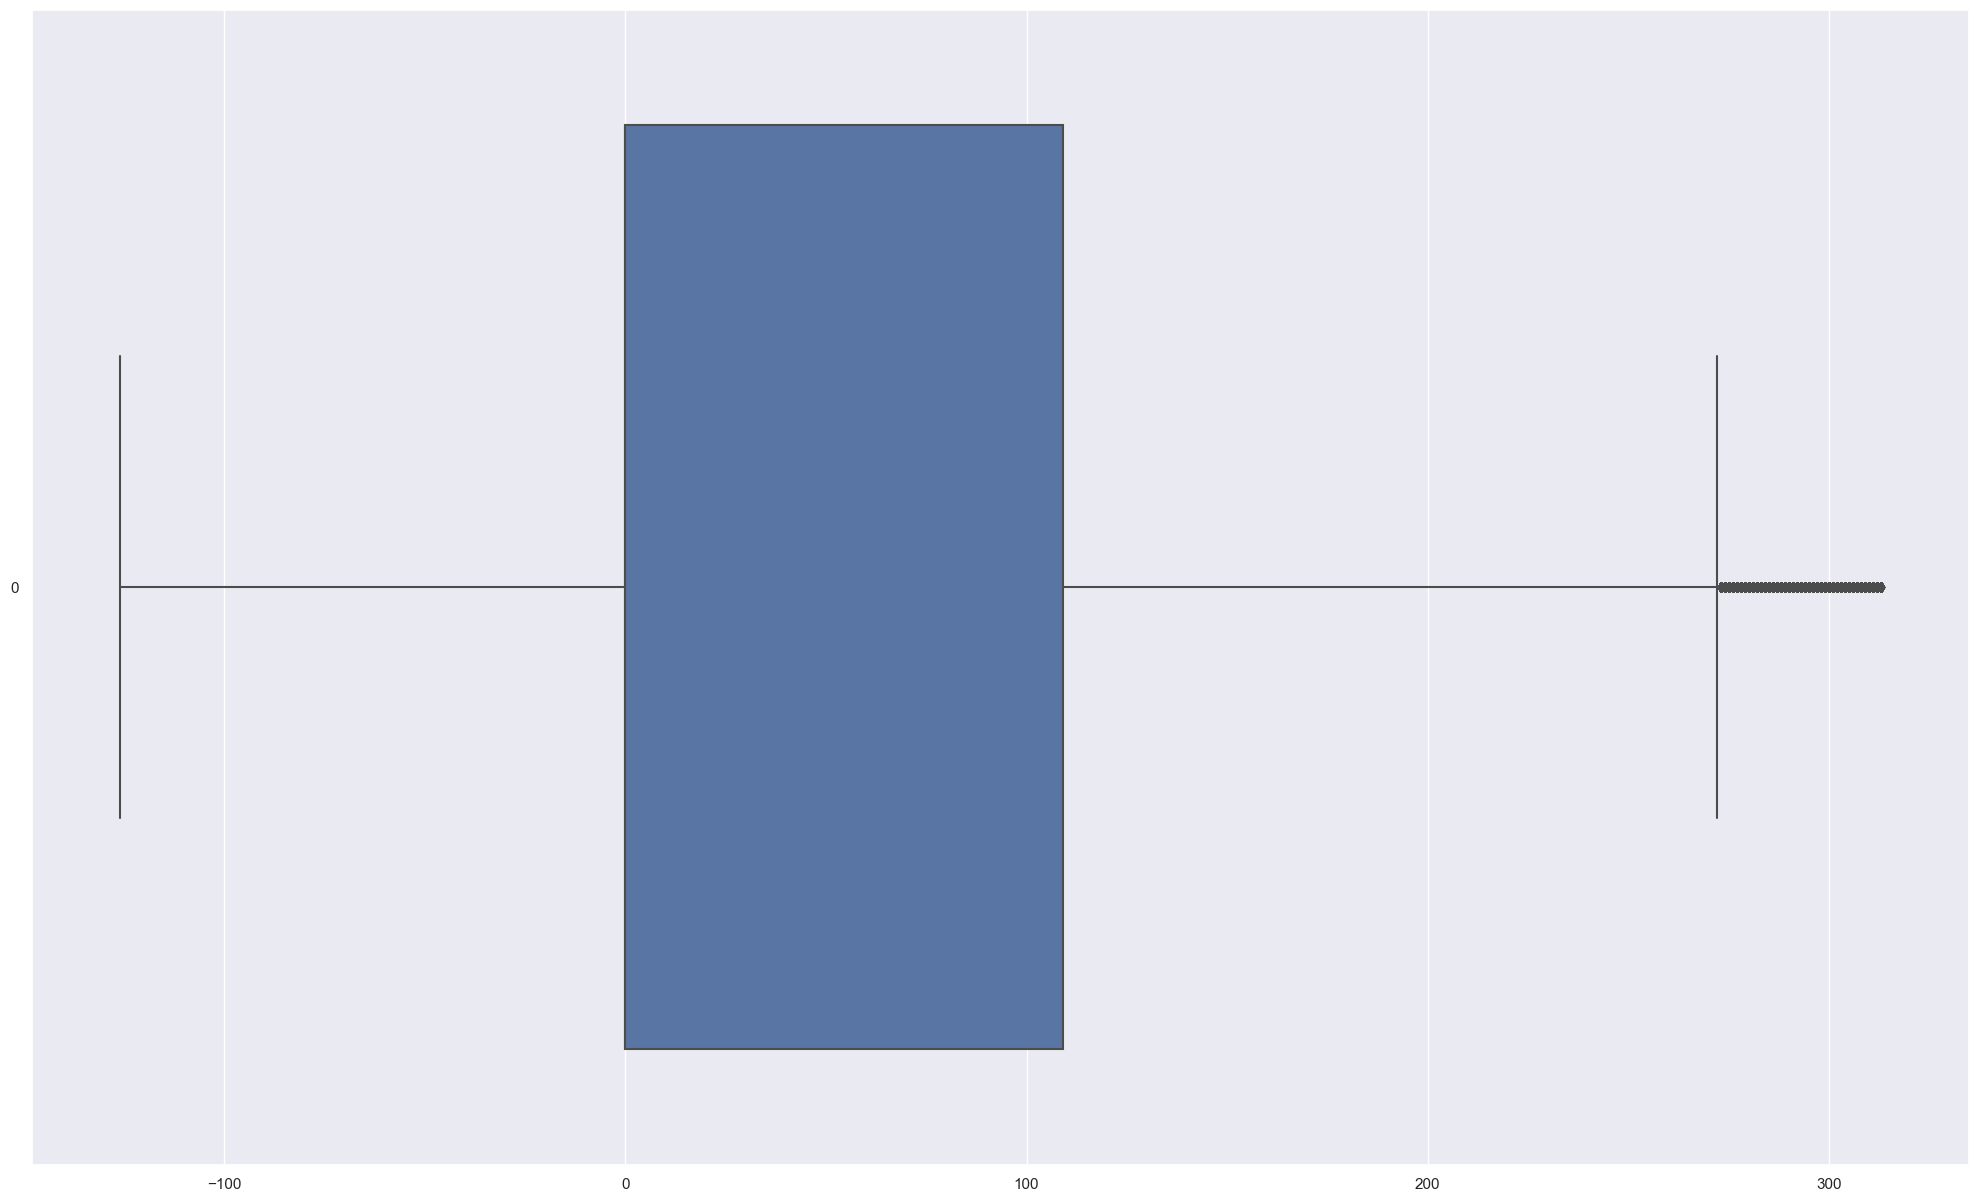

In [4]:
sns.boxplot( df5['promo_time_week'], orient='h' )

In [5]:
rs = RobustScaler()
mms = MinMaxScaler()

# rs pra quanto tem Outliers
# mms pra qndo n tem Outliers

#cometition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )

#year
df5['year'] = mms.fit_transform( df5[['year']].values )

#competition_time_month
df5['competition_since_month'] = rs.fit_transform( df5[['competition_since_month']].values )

#competition_time_year
df5['competition_since_year'] = rs.fit_transform( df5[['competition_year']].values )

#promo_time_week|
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )

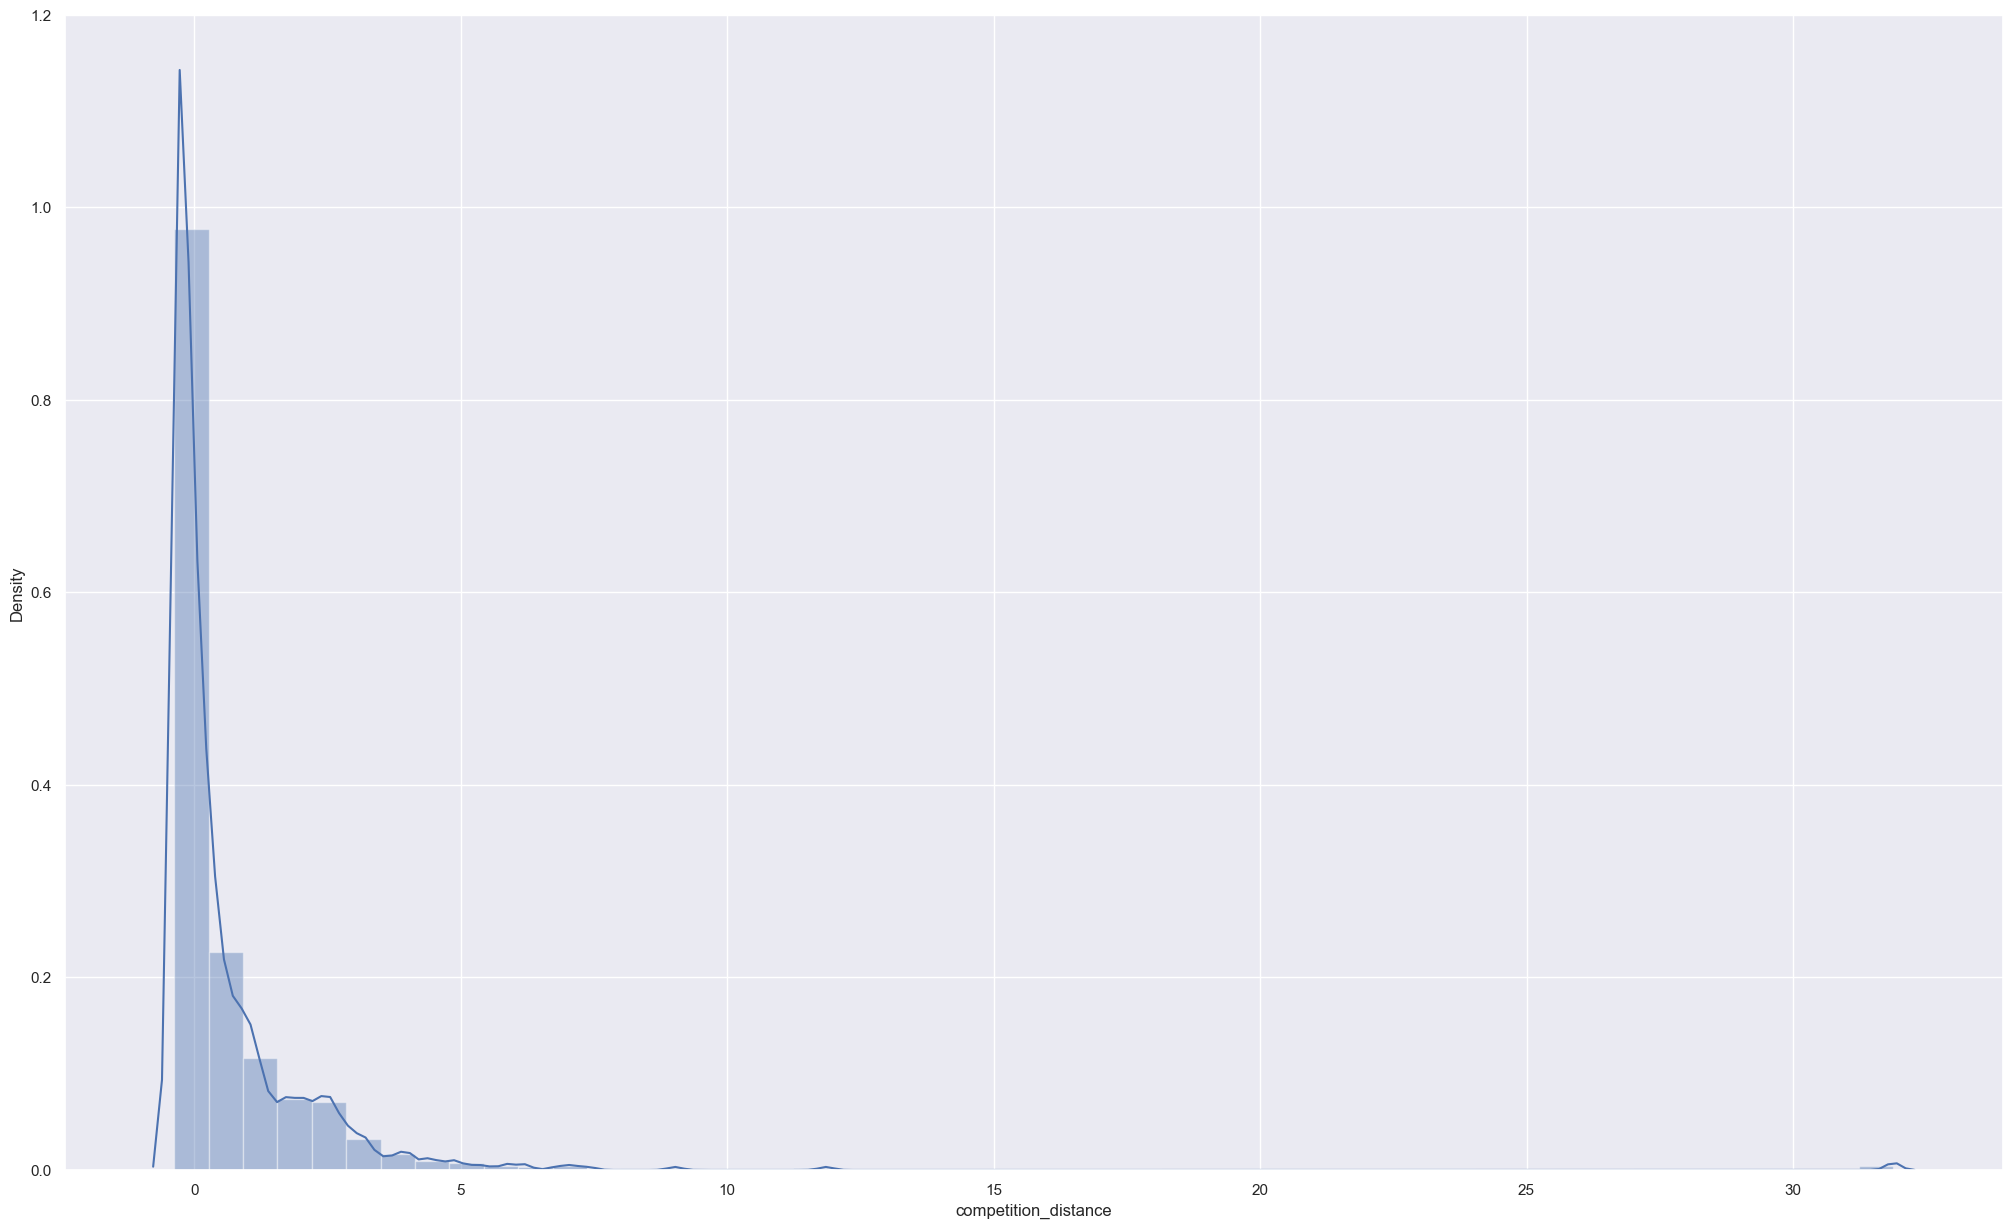

In [6]:
sns.distplot(df5['competition_distance']);

In [7]:
#month
#day
#week_of_year
#day_of_week

## 5.3. Transformacao

### 5.3.1. Encoding

One Hot Encoding - Uma nova coluna pra cada valor, e quando for true, 1 na respectiva coluna, resto 0

Label Encoding - Uma nova coluna, e um numero diferente para cada valor

Ordinal Encoding - Parecido com o de cima, mas respeitando uma ordem, no bom senso. (frio, caloroso, calor, muito calor)

Target Encoding - Media de vendas, para cada valor, e quando for o valor, colocar a media, bom quando tem muitos valores

Frequency Encoding - Funciona mais o menos pela quantidade de vezes que tal valor apareceu no dataframe

Embedding Emcoding - NLP

In [8]:
# state_holiday
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'] ) # One Hot Encoding

# store_type
le = LabelEncoder() # Label Encoding
df5['store_type'] = le.fit_transform( df5['store_type'] )

# assortment
assortment_dict = {'basic': 1, 'extended': 2, 'extra' : 3}

df5['assortment'] = df5['assortment'].map( assortment_dict ) # Ordinal Encoding

### 5.3.2. Transformacao da Variavel Resposta

<AxesSubplot:xlabel='sales', ylabel='Density'>

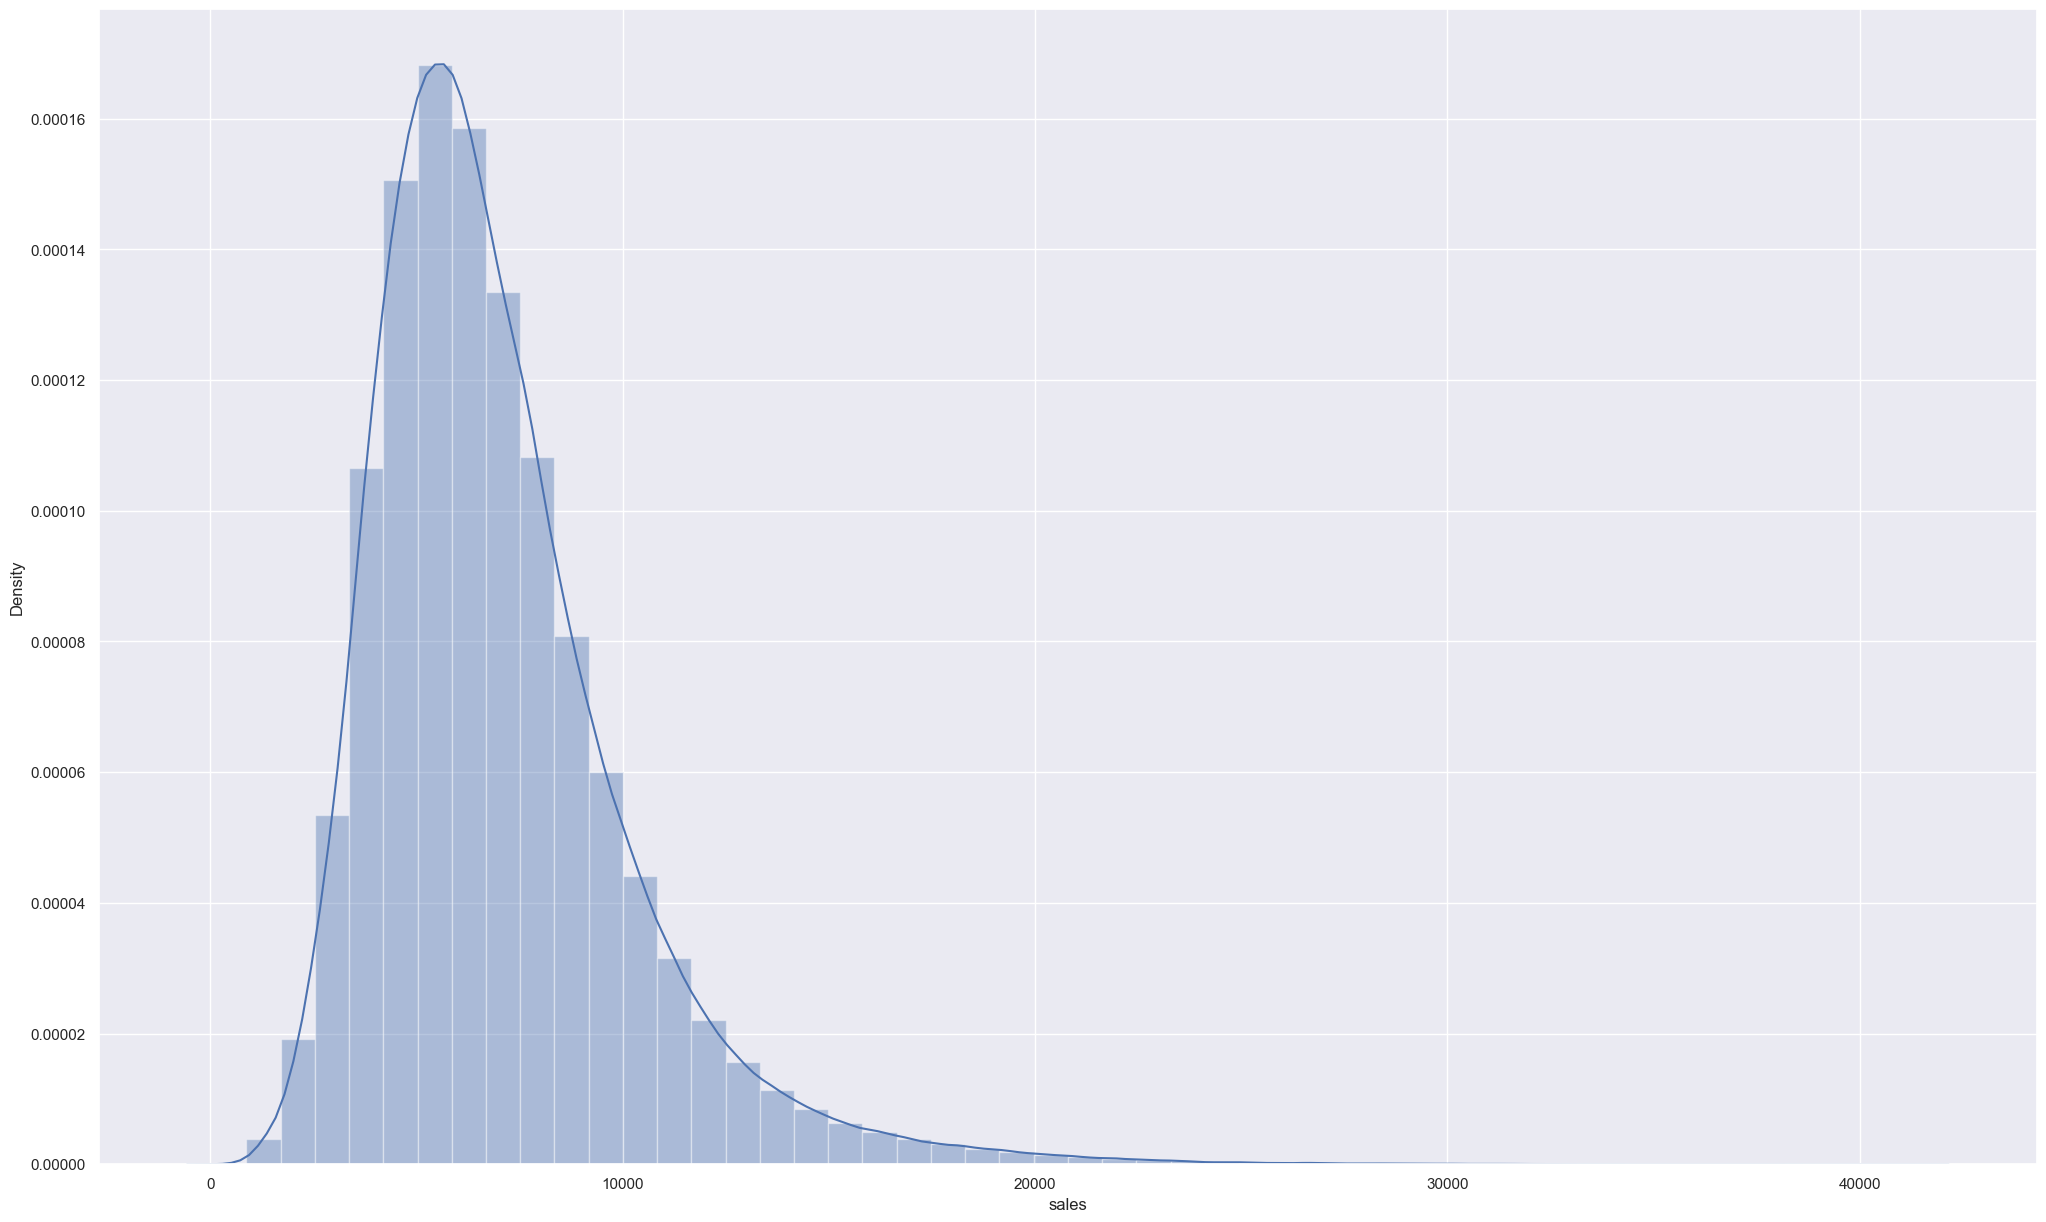

In [9]:
sns.distplot( df5['sales'] )

In [10]:
df5['sales'] = np.log1p( df5['sales'] )

<AxesSubplot:xlabel='sales', ylabel='Density'>

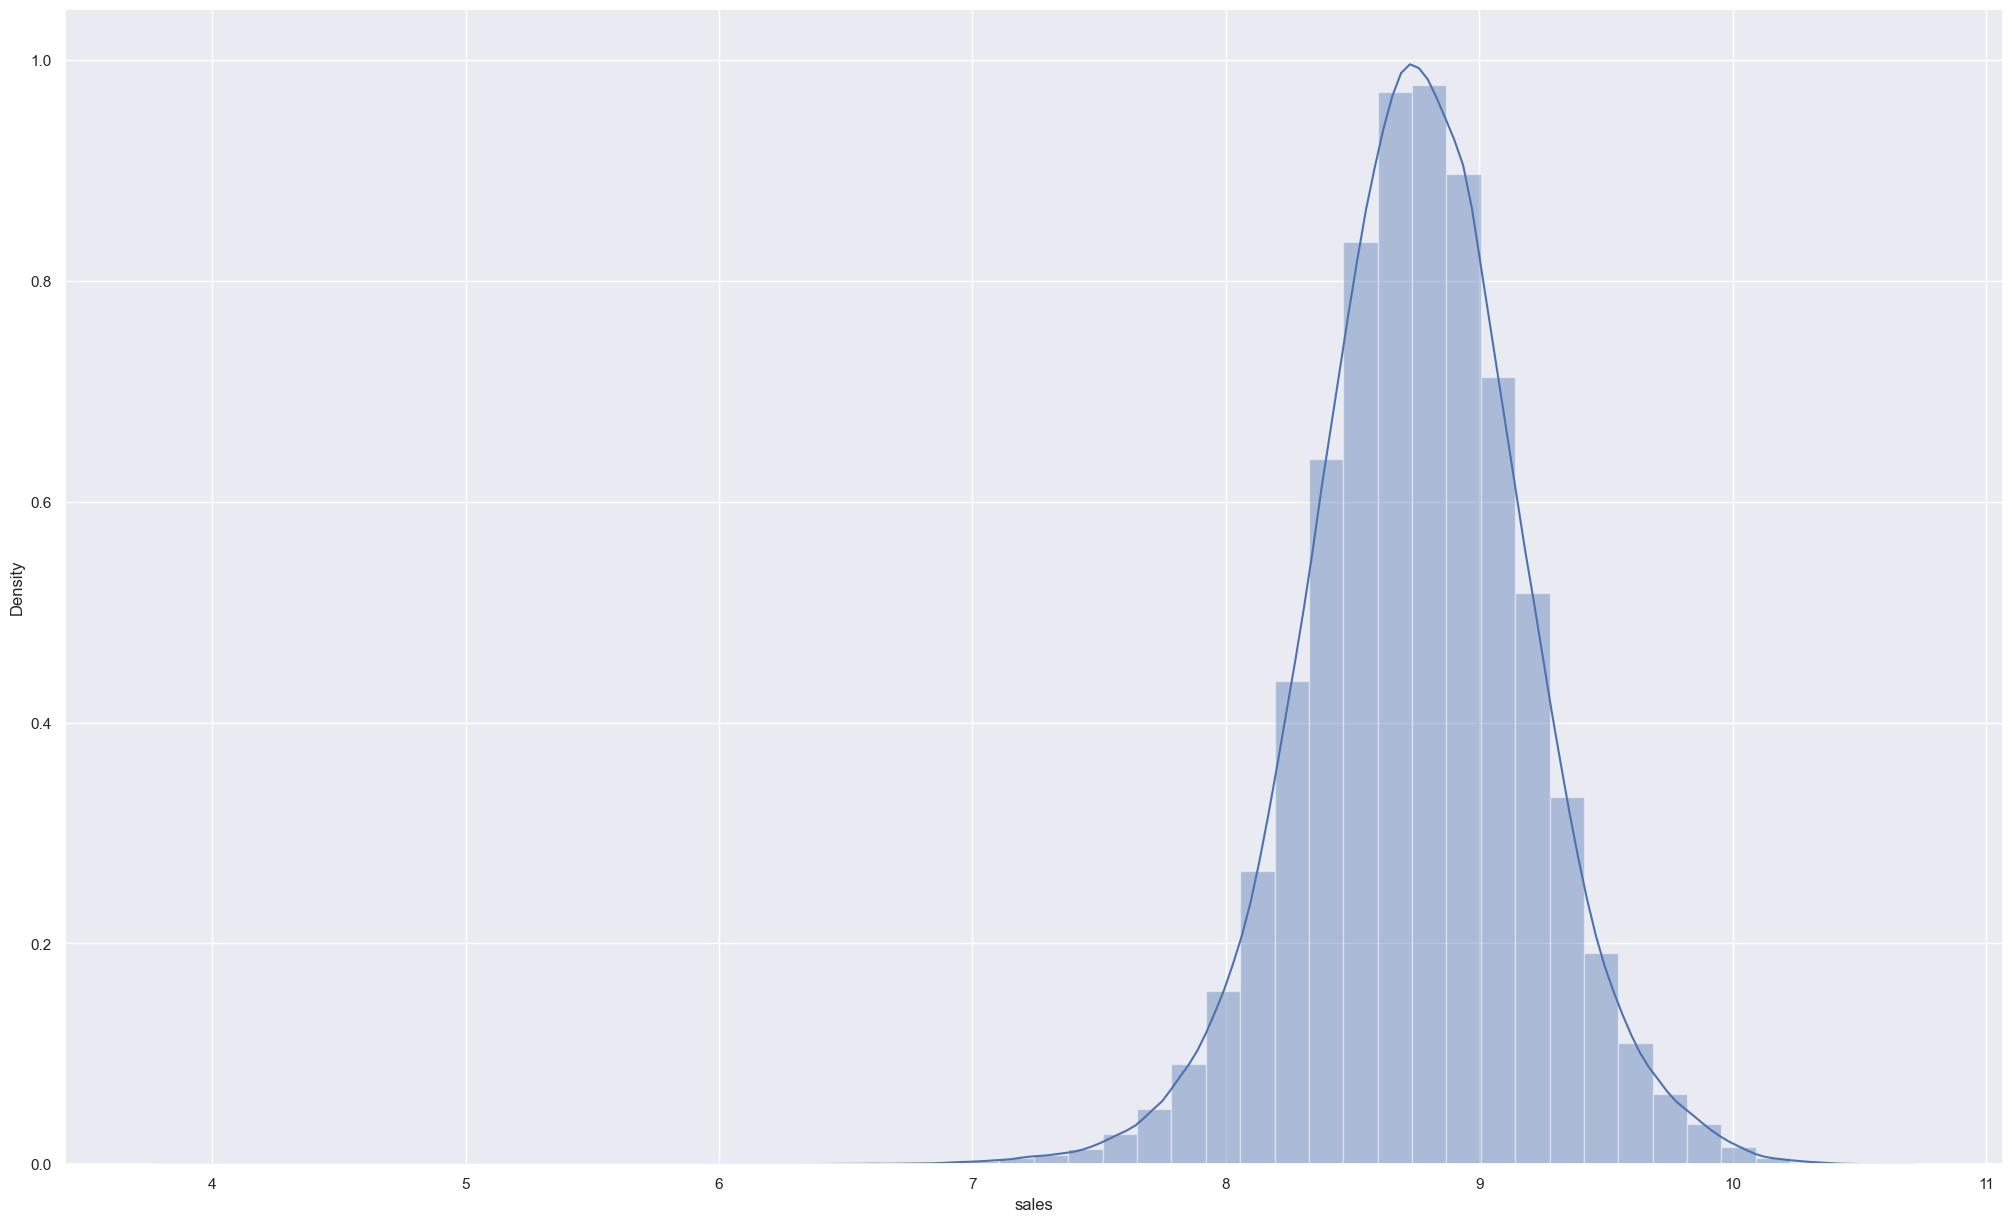

In [11]:
sns.distplot( df5['sales'] )

### 5.3.3. Transformacao de Natureza

In [12]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply( lambda x: np.sin( x * ( 2 * np.pi / 7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply( lambda x: np.cos( x * ( 2 * np.pi / 7 ) ) )

# month
df5['month_sin'] = df5['month'].apply( lambda x: np.sin( x * ( 2 * np.pi / 12 ) ) )
df5['month_cos'] = df5['month'].apply( lambda x: np.cos( x * ( 2 * np.pi / 12 ) ) )

# day
df5['day_sin'] = df5['day'].apply( lambda x: np.sin( x * ( 2 * np.pi / 30 ) ) )
df5['day_cos'] = df5['day'].apply( lambda x: np.cos( x * ( 2 * np.pi / 30 ) ) )

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply( lambda x: np.sin( x * ( 2 * np.pi / 52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply( lambda x: np.cos( x * ( 2 * np.pi / 52 ) ) )

# 6.0. Selecao de Atributos

In [3]:
df6 = pd.read_csv( 'data/df6.csv' )
df6['date'] = pd.to_datetime( df6['date'] )
df6['competition_since'] = pd.to_datetime( df6['competition_since'] )
df6['promo_since'] = pd.to_datetime( df6['promo_since'] )

In [4]:
rs = RobustScaler()
df6['competition_since_year'] = rs.fit_transform( df6[['competition_year']].values )

## 6.1. Dividir DataFrame em Conjunto de Dados de Treinamento e Teste

In [5]:
cols_drop = ['week_of_year', 'day', 'month', 'promo_since', 'competition_year', 'competition_since', 'year_week', 'competition_distance_binned', 'before_after', 'day_of_week']
df6 = df6.drop( cols_drop, axis = 1 )

In [6]:
df6[['date', 'store']].groupby( 'store' ).max().reset_index()['date'][0] - timedelta( days = 6*7 )

Timestamp('2015-06-19 00:00:00')

In [7]:
# dataset de treino
X_train = df6[df6['date'] < '2015-06-19']
Y_train = X_train['sales']

# dataset de teste
X_test = df6[df6['date'] >= '2015-06-19']
Y_test = X_test['sales']

print(f'Train min date {X_train["date"].min()}')
print(f'Train max date {X_train["date"].max()}')

print(f'test min date {X_test["date"].min()}')
print(f'test max date {X_test["date"].max()}')

Train min date 2013-01-01 00:00:00
Train max date 2015-06-18 00:00:00
test min date 2015-06-19 00:00:00
test max date 2015-07-31 00:00:00


## 6.2. Boruta como Selecao de Atributos

Selecao por importancia / Metodo Embutido : E um subproduto de aprendizado de alguns modelos
    Algoritimo Ramdom Forest: Serve tanto pra classificacao quanto pra regressao, subarvores
    Ela vai dividindo em coisas homogenias 
    
Algoritmos de regressao: Lasso Regression e Ridge Regression

selecao por subset

In [7]:
x_train_n = X_train.drop( ['date', 'sales'], axis=1 ).values
y_train_n = Y_train.values.ravel()

rf = RandomForestRegressor( n_jobs=-1 )

boruta = BorutaPy( rf, n_estimators='auto', verbose=2, random_state=42 ).fit( x_train_n, y_train_n )

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	28
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	9


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	19
Tentative: 	0
Rejected: 	9


### 6.2.1. Melhores Features do Boruta

In [8]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_since_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos',
    'competition_since_year']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

In [9]:
not_selected_boruta = [
    'is_promo',
     'month_sin',
     'school_holiday',
     'state_holiday_christmas',
     'state_holiday_easter_holiday',
     'state_holiday_public_holiday',
     'state_holiday_regular_day',
     'week_of_year_sin',
     'year'] # o ano por exemplo, nas hipoteses, foi mto relevante, entao no segundo crisp, bota ele e ve se aumenta

In [10]:
cols_selected = boruta.support_.tolist()

# best features
x_train_fs = X_train.drop( ['date', 'sales'], axis=1 )
cols_selected_boruta = list( x_train_fs.iloc[:, cols_selected].columns )

# not selected boruta
not_selected_boruta = list( np.setdiff1d( x_train_fs.columns, cols_selected_boruta ) )

In [11]:
cols_selected

[True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True]

# 7.0. Treinamento de Algoritmos de Machine Learning

In [10]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

x_training = X_train[ cols_selected_boruta_full ]

Como o RMSE dos modelos lineares ficou maior que o da media, isso significa que o problema nao e linear, e um problema complexo

## 7.1. Modelo de Media

In [31]:
aux1 = x_test.copy()
aux1['sales'] = Y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').mean().reset_index().rename( columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Avarage Model', np.expm1( Y_test ), np.expm1( yhat_baseline ) )
baseline_result

,Model_Name,MAE,MAPE,RMSE
0,Avarage Model,1354.800353,0.2064,1835.135542


## 7.2. Modelo de Regressao Linear

In [17]:
# model
lr = LinearRegression().fit( x_train, Y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', np.expm1( Y_test ), np.expm1( yhat_lr ) )
lr_result

,Model_Name,MAE,MAPE,RMSE
0,Linear Regression,1858.712447,0.28517,2684.283301


###  7.2.1 Modelo de Regressao Linear - Cross-Validation

In [21]:
lr_result_cv = cross_validation( x_training, 5, 'LinearRegression', lr, verbose=False )
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,LinearRegression,2037.26 +/- 268.66,0.3 +/- 0.01,2908.23 +/- 399.53


## 7.3. Modelo de Regressao Linear Regularizada - Lasso

In [23]:
# model
lrr = Lasso( alpha=0.001 ).fit( x_train, Y_train )

# prediction
yhat_lrr = lrr.predict( x_test )
 
# performance
lrr_result = ml_error( 'Linear Regression - Lasso', np.expm1( Y_test ), np.expm1( yhat_lrr ) )
lrr_result

,Model_Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1864.159587,0.287184,2686.040626


### 7.3.1 Lasso - Cross-Validation

In [25]:
lrr_result_cv = cross_validation( x_training, 5, 'Linear Regression - Lasso', lrr )
lrr_result_cv

KFold number 5
KFold number 4
KFold number 3
KFold number 2
KFold number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression - Lasso,2085.52 +/- 327.35,0.29 +/- 0.01,2982.39 +/- 500.42


## 7.4. Modelo de Regressao Random Forest

In [26]:
# model
rf = RandomForestRegressor(n_estimators=450, n_jobs=-1,
                           random_state=42).fit(x_train, Y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest Regressor', np.expm1(Y_test),
                     np.expm1(yhat_rf))
rf_result

,Model_Name,MAE,MAPE,RMSE
0,Random Forest Regressor,673.891784,0.099192,1003.873578


### 7.4..1 Regressao Random Forest - Cross Validation

In [27]:
rf_result_cv = cross_validation( x_training, 5, 'Random Forest Regressor', rf )
rf_result_cv

KFold number 5
KFold number 4
KFold number 3
KFold number 2
KFold number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,832.88 +/- 217.69,0.12 +/- 0.02,1250.45 +/- 317.81


## 7.5. XGBoost Regressor

In [28]:
# model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=2500,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytree=0.9).fit(x_train, Y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# pemodel_xgbormance
model_xgb_result = ml_error('XGBoost Regressor', np.expm1(Y_test),
                            np.expm1(yhat_xgb))
model_xgb_result

,Model_Name,MAE,MAPE,RMSE
0,XGBoost Regressor,660.277741,0.095625,969.670432


### 7.5.1 XGBoost Regressor - Cross Validation

In [29]:
model_xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor',
                                       model_xgb)
model_xgb_result_cv

KFold number 5
KFold number 4
KFold number 3
KFold number 2
KFold number 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,837.67 +/- 146.0,0.12 +/- 0.01,1210.7 +/- 209.0


## 7.6. Comparar a Performace dos Modelos

In [110]:
# venda menor
a = np.expm1(Y_test).min()
# venda maior
b = np.expm1(Y_test).max()
# range da venda
c = b - a
d = np.expm1(Y_test).mean()

# MAE calcula o erro, que é basicamente a diferenca do y pro yhat
print(f'O MAE foi de {round(xgb_result_tuned["MAE"][0])}, e o range das vendas é de {round(c)}, entao foi um erro baixo')
print(f'É possivel calcular a % do erro, que pe o MAPE, {round(626/d, 3)}%, sendo assim, proximo de 9%, ou seja, a % que falta media para o acerto na media')
print(f'O RMSE é parecido com o MAE, mas em vez dele aplicar o modulo ele elevar ao quadrado, sendo assim, é mais sensivel a outliers')
print(f'O MPE indica se as predicoes estao sendo positivas ou negativas, para ter uma nocao')

O MAE foi de 626, e o range das vendas é de 40982, entao foi um erro baixo
É possivel calcular a % do erro, que pe o MAPE, 0.089%, sendo assim, proximo de 9%, ou seja, a % que falta media para o acerto na media
O RMSE é parecido com o MAE, mas em vez dele aplicar o modulo ele elevar ao quadrado, sendo assim, é mais sensivel a outliers
O MPE indica se as predicoes estao sendo positivas ou negativas, para ter uma nocao


### 7.6.1 Single Performance

In [32]:
modelling_result = pd.concat(
    [baseline_result, lr_result, lrr_result, rf_result, model_xgb_result])

modelling_result.sort_values('RMSE')

,Model_Name,MAE,MAPE,RMSE
0,XGBoost Regressor,660.277741,0.095625,969.670432
0,Random Forest Regressor,673.891784,0.099192,1003.873578
0,Avarage Model,1354.800353,0.206400,1835.135542
0,Linear Regression,1858.712447,0.285170,2684.283301
0,Linear Regression - Lasso,1864.159587,0.287184,2686.040626


### 7.6.2 Real Performance - Cross Validation

In [34]:
modelling_result_cv = pd.concat(
    [lr_result_cv, lrr_result_cv, rf_result_cv, model_xgb_result_cv])

modelling_result_cv.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,837.67 +/- 146.0,0.12 +/- 0.01,1210.7 +/- 209.0
0,Random Forest Regressor,832.88 +/- 217.69,0.12 +/- 0.02,1250.45 +/- 317.81
0,LinearRegression,2037.26 +/- 268.66,0.3 +/- 0.01,2908.23 +/- 399.53
0,Linear Regression - Lasso,2085.52 +/- 327.35,0.29 +/- 0.01,2982.39 +/- 500.42


# 8.0. Fine Tunning

## 8.1. Ramdom Search

In [31]:
param = {
    'n_estimators': [100, 500, 1000, 1500, 2000, 2500, 3500],
    'eta': [0.1, 0.01, 0.03],
    'max_depth': [10, 5, 8],
    'subsample': [0.1, 0.7, 0.10],
    'colsample_bytree': [0.9, 0.3, 0.5],
    'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 10

In [32]:
final_result = pd.DataFrame()

for i in range( MAX_EVAL ):
    
    # choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0]  for k, v in param.items()}
    print(hp)

    # model
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytree=hp['colsample_bytree'],
                                 min_child_weight=hp['min_child_weight'])
    
    
    # performance
    model_xgb_rs = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb )
    final_result = pd.concat( [final_result, model_xgb_rs] )
    
final_result

{'n_estimators': 1000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 8}
KFold number 5
KFold number 4
KFold number 3
KFold number 2
KFold number 1
{'n_estimators': 1500, 'eta': 0.01, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.9, 'min_child_weight': 3}
KFold number 5
KFold number 4
KFold number 3
KFold number 2
KFold number 1
{'n_estimators': 2000, 'eta': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.3, 'min_child_weight': 15}
KFold number 5
KFold number 4
KFold number 3
KFold number 2
KFold number 1
{'n_estimators': 3500, 'eta': 0.03, 'max_depth': 10, 'subsample': 0.7, 'colsample_bytree': 0.5, 'min_child_weight': 3}
KFold number 5
KFold number 4
KFold number 3
KFold number 2
KFold number 1
{'n_estimators': 500, 'eta': 0.03, 'max_depth': 10, 'subsample': 0.1, 'colsample_bytree': 0.9, 'min_child_weight': 15}
KFold number 5
KFold number 4
KFold number 3
KFold number 2
KFold number 1
{'n_estimators': 500, 'eta': 0.1

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1355.15 +/- 135.04,0.19 +/- 0.01,1966.43 +/- 181.7
0,XGBoost Regressor,1500.88 +/- 166.1,0.21 +/- 0.01,2173.64 +/- 218.79
0,XGBoost Regressor,1135.84 +/- 110.72,0.16 +/- 0.01,1633.89 +/- 150.07
0,XGBoost Regressor,773.39 +/- 118.72,0.11 +/- 0.01,1130.0 +/- 182.95
0,XGBoost Regressor,929.22 +/- 159.2,0.13 +/- 0.01,1341.43 +/- 224.77
0,XGBoost Regressor,1057.33 +/- 147.21,0.15 +/- 0.01,1518.15 +/- 192.47
0,XGBoost Regressor,826.19 +/- 128.49,0.11 +/- 0.01,1196.17 +/- 195.11
0,XGBoost Regressor,828.23 +/- 149.01,0.12 +/- 0.01,1196.5 +/- 212.48
0,XGBoost Regressor,878.17 +/- 108.59,0.12 +/- 0.01,1248.16 +/- 163.02
0,XGBoost Regressor,1059.35 +/- 144.92,0.14 +/- 0.01,1540.3 +/- 211.16


## 8.2. Modelo Final

In [11]:
param_tuned = {
    'n_estimators':3500,
    'eta': 0.03,
    'max_depth': 10,
    'subsample': 0.7,
    'colsample_bytree': 0.5,
    'min_child_weight': 3
}

In [12]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytree=param_tuned['colsample_bytree'],
                             min_child_weight=param_tuned['min_child_weight']).fit(
                                 x_train, Y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict( x_test )

# performance
xgb_result_tuned = ml_error( 'XGBoost Regressor', np.expm1( Y_test ), np.expm1( yhat_xgb_tuned ) )
xgb_result_tuned

,Model_Name,MAE,MAPE,RMSE
0,XGBoost Regressor,626.46385,0.09049,916.07867


In [13]:
mpe = mean_percentage_error(np.expm1(Y_test), np.expm1(yhat_xgb_tuned))
mpe

0.007997090437541246

In [14]:
X_test.to_csv('data/X_test.csv', index=False)

In [23]:
df = pd.DataFrame (cols_selected_boruta_full, columns = ['columns'])

In [30]:
df.to_csv('data/cols_selected_boruta_full.csv', index=False)
df.to_csv('data/yhat_xgb_tuned.csv', index=False)

In [29]:
df = pd.DataFrame (yhat_xgb_tuned, columns = ['columns'])

,columns
0,8.61027
1,8.62991
2,9.17033
3,9.34677
4,8.75821
...,...
41391,8.69074
41392,9.30950
41393,8.83828
41394,10.00779


# 9.0. Traducao e Interpretacao do Erro

In [5]:
a = ['store', 'promo', 'store_type', 'assortment', 'competition_distance',
          'competition_open_since_month', 'competition_open_since_year',
          'promo2', 'promo2_since_week', 'promo2_since_year',
          'competition_since_month', 'promo_time_week', 'day_of_week_sin',
          'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin', 'day_cos',
          'week_of_year_sin', 'week_of_year_cos', 'competition_since_year',
          'date', 'sales']

In [6]:
df9 = pd.read_csv('data/X_test.csv')
df9 = df9[a]
df9['sales'] = np.expm1( df9['sales'] )
df9['predictions'] = np.expm1( pd.read_csv('data/yhat_xgb_tuned.csv') )
df9['date'] = pd.to_datetime( df9['date'] )

## Performace de Negocio

In [7]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE e MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(
    lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAE'} )

df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(
    lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename( columns={0:'MAPE'} )

# merge
df9_aux3 = pd.merge( df9_aux1, df9_aux2, how='inner', on='store' )
df92 = pd.merge( df91, df9_aux3, how='inner', on='store' )

# cenarios
df92['pior_cenario'] = df92['predictions'] - df92['MAE']
df92['melhor_cenario'] = df92['predictions'] + df92['MAE']

# ordenar colunas
df92 = df92[['store', 'predictions', 'pior_cenario', 'melhor_cenario', 'MAE', 'MAPE']]



In [8]:
df92.sort_values( 'MAPE', ascending=False ).head()

,store,predictions,pior_cenario,melhor_cenario,MAE,MAPE
291,292,105648.35961,102365.17463,108931.54459,3283.18498,0.55466
908,909,241924.96787,234290.98822,249558.94753,7633.97965,0.53016
875,876,200828.36383,197000.57988,204656.14779,3827.78395,0.28472
182,183,200058.47727,198626.71642,201490.23813,1431.76085,0.23401
99,100,353940.93602,352244.75979,355637.11225,1696.17623,0.21974


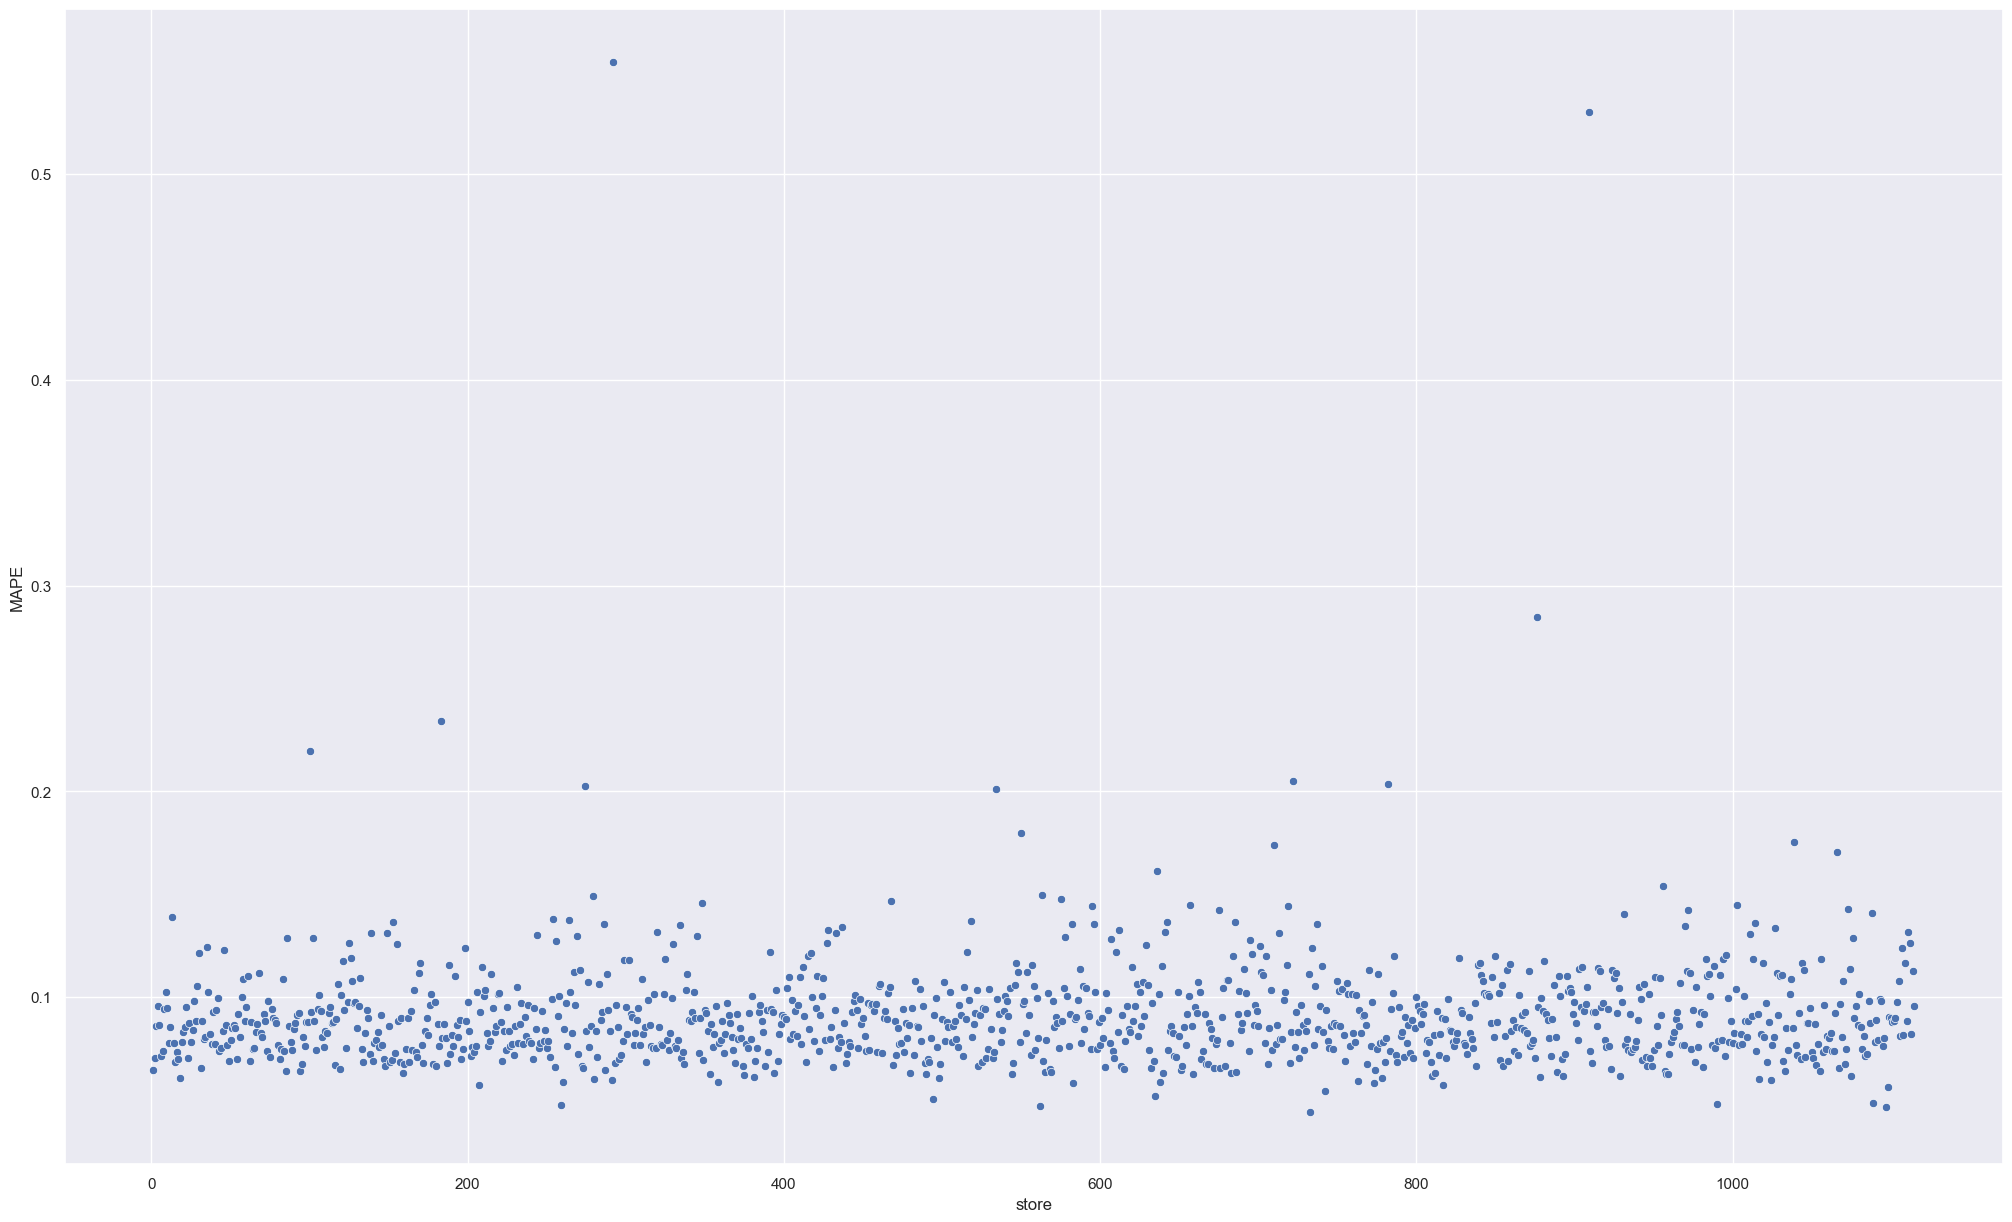

In [9]:
sns.scatterplot( x='store', y='MAPE', data=df92 );

## Performace Total

In [10]:
df93 = df92[['predictions', 'melhor_cenario', 'pior_cenario'
      ]].apply(lambda x: np.sum(x),
               axis=0).reset_index().rename(columns={'index': 'cenario', 0:'valores'})

df93['valores'] = df93['valores'].map( 'R${:,.2f}'.format )
df93

,cenario,valores
0,predictions,"R$283,143,191.05"
1,melhor_cenario,"R$283,846,001.25"
2,pior_cenario,"R$282,440,380.85"


## Machine Learning Performace

In [11]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

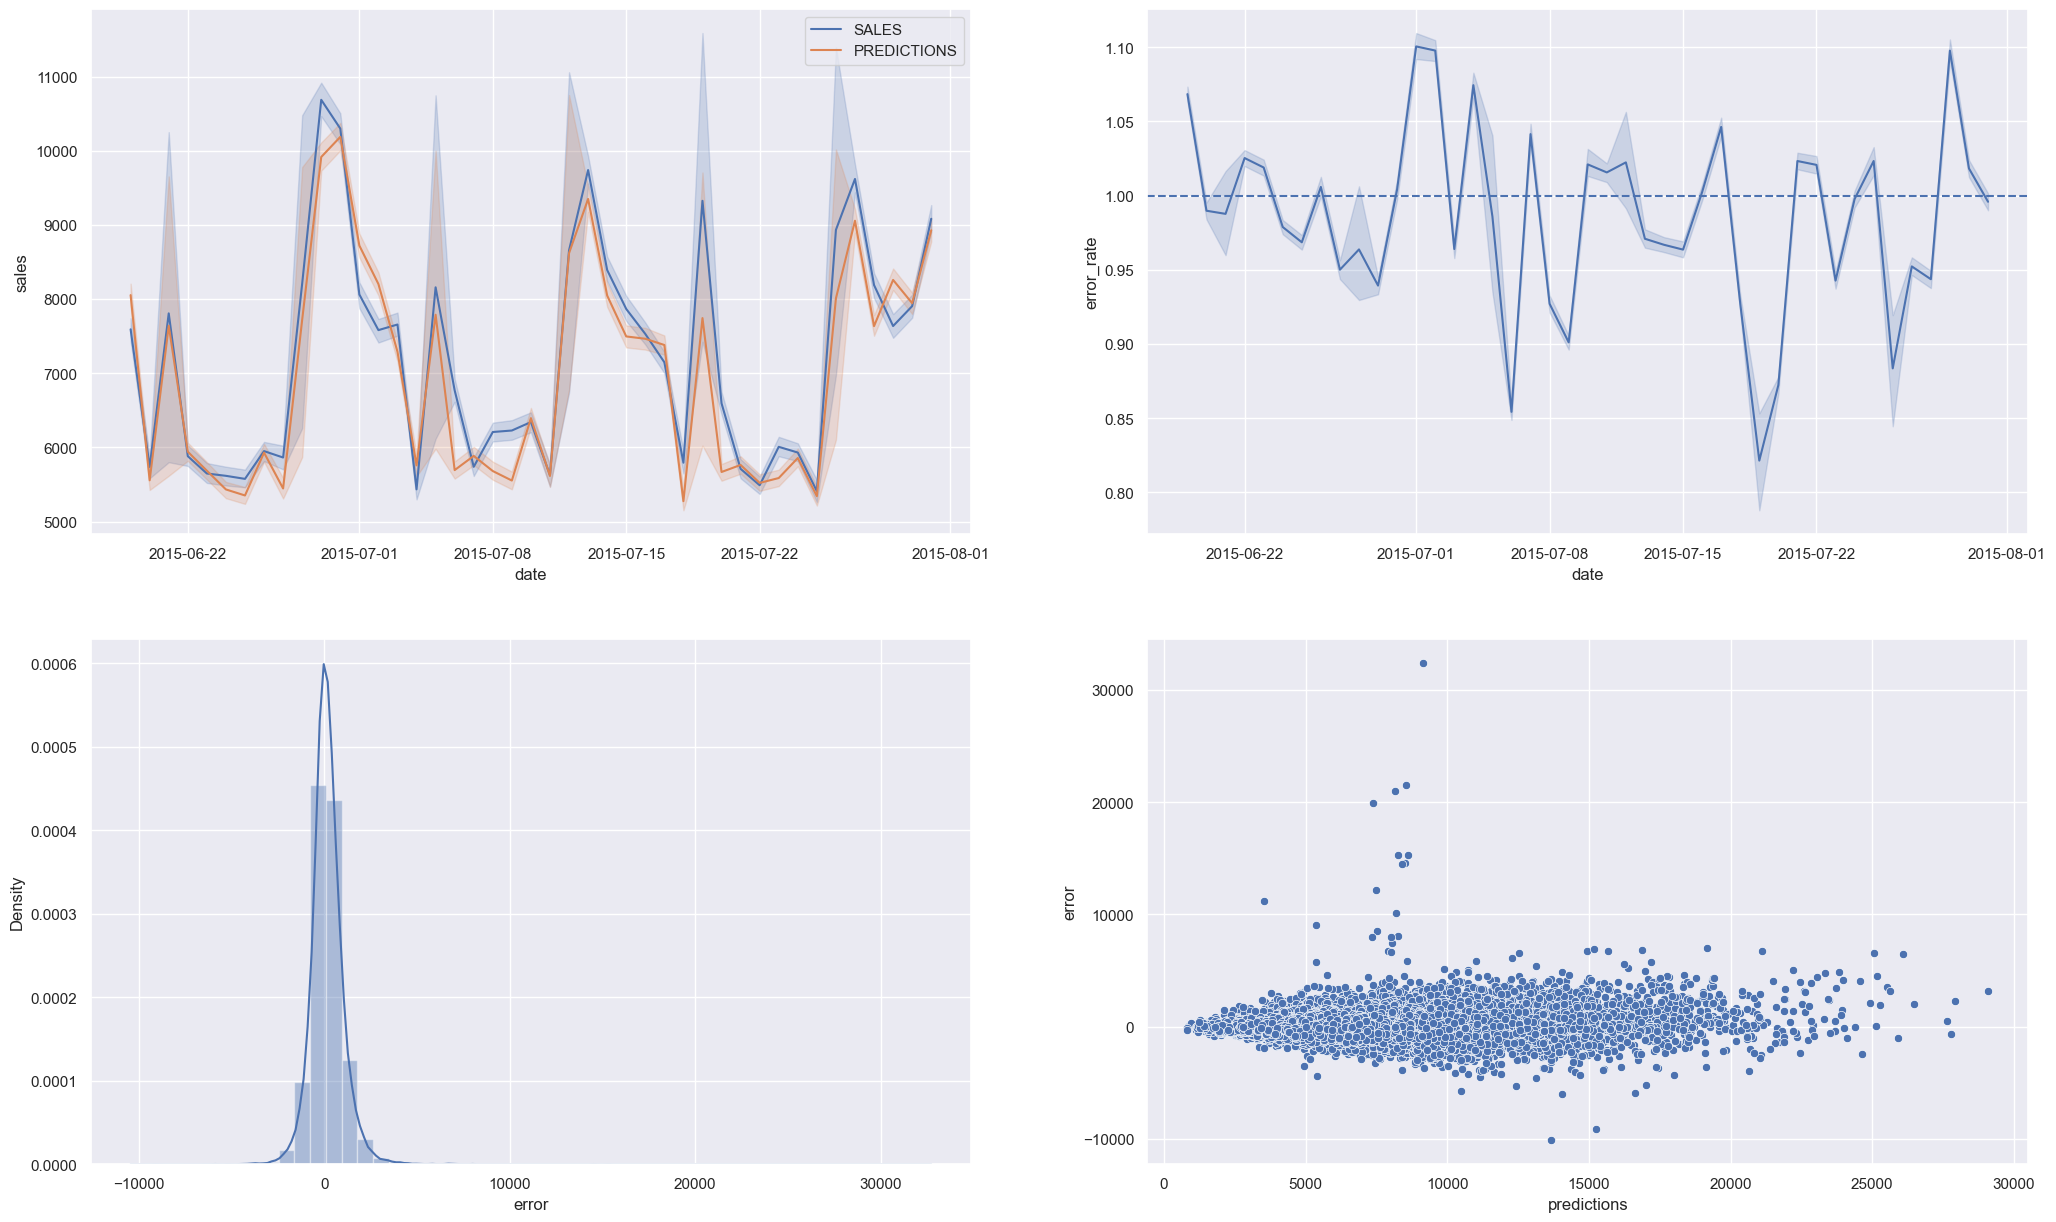

In [12]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='date', y='sales', data=df9, label='SALES' )
sns.lineplot( x='date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--' )

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( x=df9['predictions'], y=df9['error'] );